In [10]:
#Import necessary libraries
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [8]:
#Function to read parquet file
def read_parquet_file(file_path):
    df = pd.read_parquet(file_path)
    return df

In [11]:
#Importing document
file_path = '/Users/salmahoumane/Downloads/24-07-31_2w_all_events.parquet'
df = read_parquet_file(file_path)

In [26]:
# Print the column names
print("Column names:")
print(df.columns)

Column names:
Index(['UNITNO', 'SCAN_DATETIME', 'EVENT_CODE', 'EVENT_REASON', 'WEIGHT',
       'VOLUME', 'STACKABLE', 'SMALL', 'HAZARDOUS', 'BELT',
       'DESTINATION_ZIPCODE', 'EVENT_TYPE', 'RAW_DESTINATION_DEPOT_ID',
       'RAW_SCAN_DEPOT_ID', 'DESTINATION_DEPOT_ID', 'SCAN_DEPOT_ID',
       'DESTINATION_SCAN_DATETIME', 'FIRST_SCAN_DATETIME', 'NEXT_DEPOT_ID',
       'NEXT_SCAN_DATETIME', 'PREVIOUS_DEPOT_ID', 'PREVIOUS_SCAN_DATETIME',
       'SCAN_WEEK_OF_YEAR', 'SCAN_DAY_OF_WEEK', 'IS_FRIDAY', 'SCAN_HOUR',
       'SCAN_MINUTE', 'SCAN_BEFORE_10'],
      dtype='object')


In [13]:
# Rename the column 'EVENT_REASON' to 'EVENT_R'
df = df.rename(columns={'EVENT_REASON': 'EVENT_R'})

In [14]:
#Concatenating event code and event reason
df['EVENT_REASON'] = df['EVENT_CODE'].astype(str) + '-' + df['EVENT_R'].astype(str)

In [15]:
# Convert datetime columns to datetime type
df['DESTINATION_SCAN_DATETIME'] = pd.to_datetime(df['DESTINATION_SCAN_DATETIME'])
df['FIRST_SCAN_DATETIME'] = pd.to_datetime(df['FIRST_SCAN_DATETIME'])
# Add a new column for the week of the year
df['SCAN_WEEK_OF_YEAR'] = df['SCAN_DATETIME'].dt.strftime("%V").astype(str).astype(int)
# Add a new column for the day of the week
df['SCAN_DAY_OF_WEEK'] = df['SCAN_DATETIME'].dt.dayofweek
# Add a new column to indicate if the scan happened on a Friday
df['IS_FRIDAY'] = df['SCAN_DATETIME'].dt.dayofweek == 4
# Add a new column for the hour of the scan
df['SCAN_HOUR'] = df['SCAN_DATETIME'].dt.hour
# Add a new column for the minute of the scan
df['SCAN_MINUTE'] = df['SCAN_DATETIME'].dt.minute
# Add a new column to indicate if the scan happened before 10 AM
df['SCAN_BEFORE_10'] = df['SCAN_HOUR'] < 10

# Analyzing Event Reason

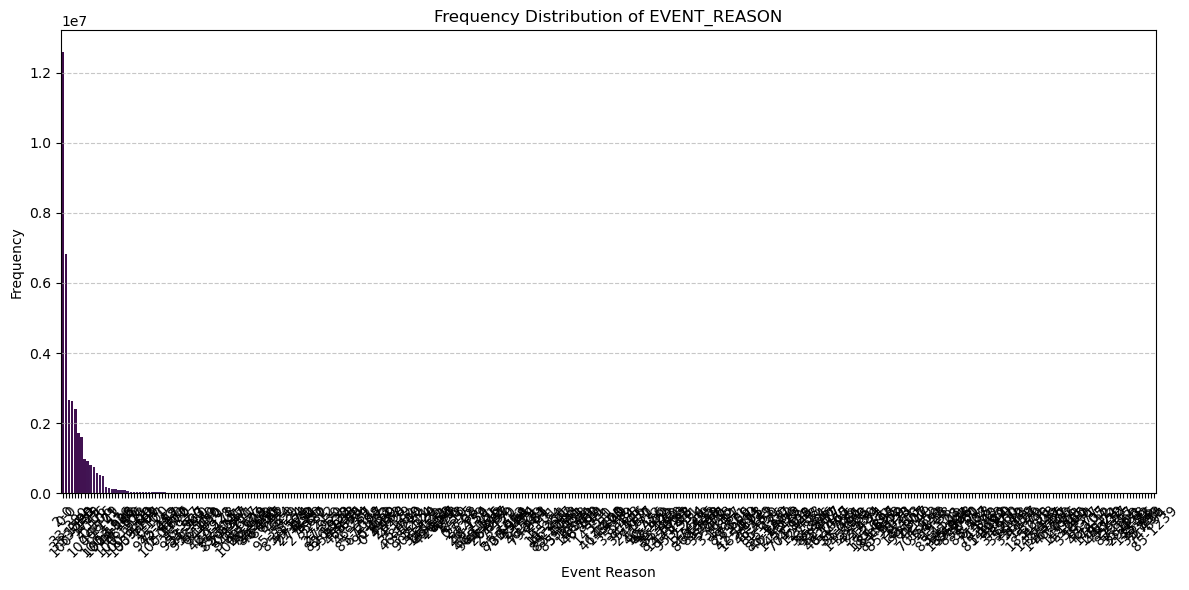

In [253]:
# Calculate frequency distribution of EVENT_REASON
event_reason_counts = df['EVENT_REASON'].value_counts().reset_index()
event_reason_counts.columns = ['EVENT_REASON', 'Frequency']

# Plot the frequency distribution using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='EVENT_REASON', y='Frequency', data=event_reason_counts, palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of EVENT_REASON')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

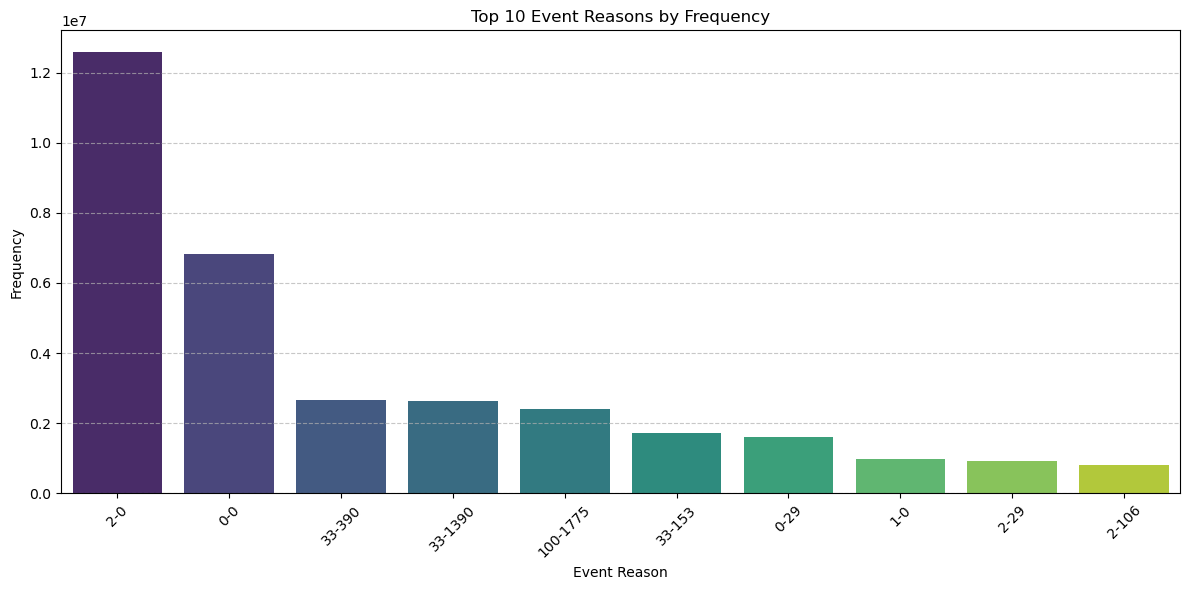

In [255]:
#Step 2: Get the top 10 EVENT_REASON values
top_10_event_reasons = event_reason_counts.nlargest(10, 'Frequency')

# Step 3: Plot the frequency distribution using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='EVENT_REASON', y='Frequency', data=top_10_event_reasons, palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Frequency')
plt.title('Top 10 Event Reasons by Frequency')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

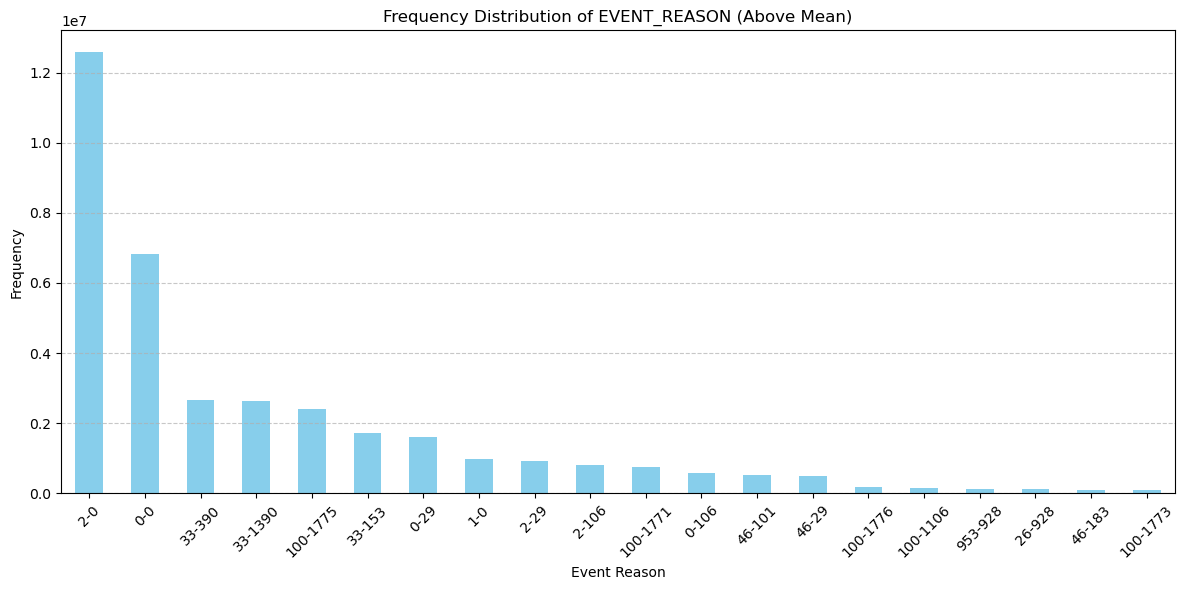

In [257]:
# Step 1: Calculate frequency distribution of EVENT_REASON
event_reason_counts = df['EVENT_REASON'].value_counts()

# Step 2: Calculate mean frequency
mean_frequency = event_reason_counts.mean()

# Step 3: Filter event reasons with frequency higher than the mean
filtered_event_reasons = event_reason_counts[event_reason_counts > mean_frequency]

# Step 4: Plot the filtered frequency distribution
plt.figure(figsize=(12, 6))
filtered_event_reasons.plot(kind='bar', color='skyblue')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of EVENT_REASON (Above Mean)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

- Event code 2-0: Inbound - normal
- Event code 0.0: Data creation - normal
- Event code 33-390: Change completed for - Volume weight
- Event code 33-1390: Change completed for - Volume weight GER
- Event code 100-1775: Volume Measurement - No exceeding
- Event code 0-29: Data Creation - Sorted as Business - Small Parcel
- Event code 1-0: Outbound - Normal
- Event code 2-29: Inbound - Sorted as Business - Small Parcel
- Event code 2-106:Inbound - Non-Conveyable Manually Sorted


In [16]:
# Define a function to calculate the cutoff time
def next_10am_after(scan_time, IS_FRIDAY, scan_hour):
    if scan_hour < 10:
        # If the scan is before 10 AM, set cutoff to the next day's 10 AM
        next_day = scan_time + pd.Timedelta(days=1)
        cutoff_time = next_day.replace(hour=10, minute=0, second=0, microsecond=0)
    else:
        if IS_FRIDAY:
            # If the scan is on Friday and after 10 AM, set cutoff to Monday 10 AM
            next_monday = scan_time + pd.Timedelta(days=(7 - scan_time.weekday())) # 7 - weekday() gives the days to Monday
            cutoff_time = next_monday.replace(hour=10, minute=0, second=0, microsecond=0)
        else:
            # Otherwise, set cutoff to the next day's 10 AM
            next_day = scan_time + pd.Timedelta(days=1)
            cutoff_time = next_day.replace(hour=10, minute=0, second=0, microsecond=0)
    return cutoff_time

In [17]:
# Drop duplicate rows based on 'UNITNO' and 'EVENT_REASON', keeping only the first occurrence
df_unique = df.drop_duplicates(subset=['UNITNO', 'EVENT_REASON'], keep='first')
# Apply the function to calculate the cutoff time for each row
df_unique['cutoff_time'] = df_unique.apply(
    lambda row: next_10am_after(row['FIRST_SCAN_DATETIME'], row['IS_FRIDAY'], row['SCAN_HOUR']),
    axis=1
)
# Create the `on_time` variable based on the new criteria
df_unique['ON_TIME'] = df_unique['DESTINATION_SCAN_DATETIME'] <= df_unique['cutoff_time']

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_76032/3594250130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['cutoff_time'] = df_unique.apply(
/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_76032/3594250130.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['ON_TIME'] = df_unique['DESTINATION_SCAN_DATETIME'] <= df_unique['cutoff_time']


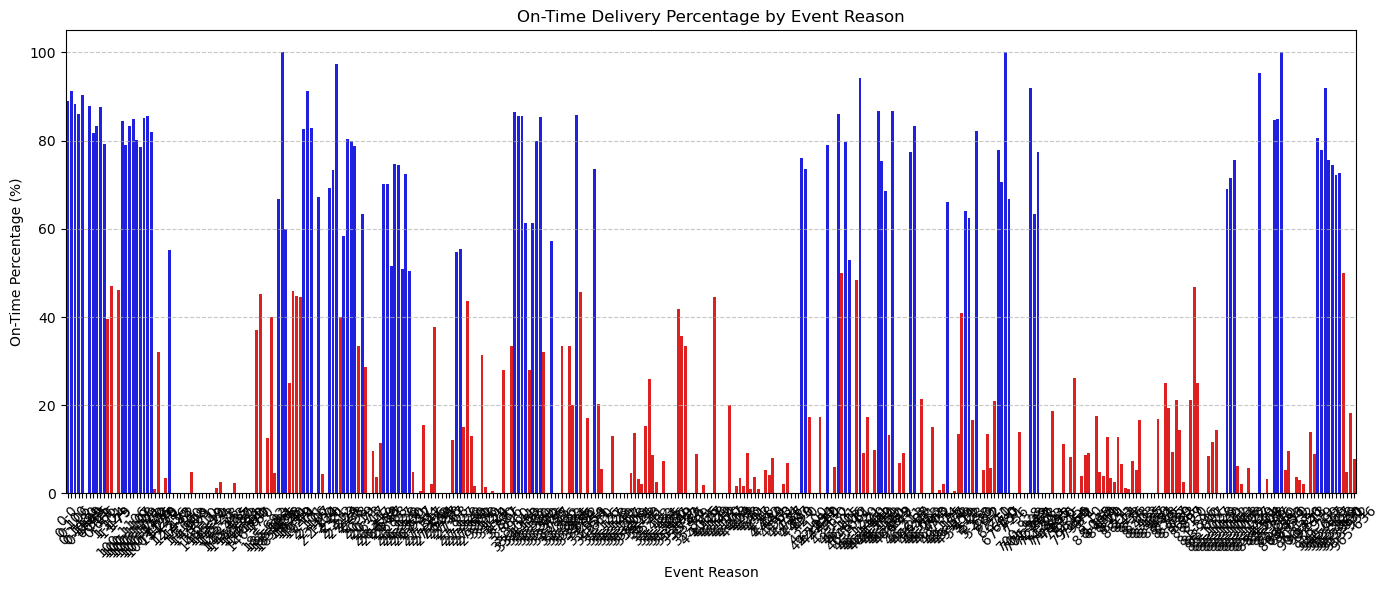

In [261]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage
on_time_percentage = df_unique.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Create a bar plot with conditional coloring
plt.figure(figsize=(14, 6))

# Determine colors based on the condition (above or below 50%)
colors = ['blue' if x > 50 else 'red' for x in on_time_percentage.values]

# Plot the bar plot with the specified colors
sns.barplot(x=on_time_percentage.index, y=on_time_percentage.values, palette=colors)

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('On-Time Percentage (%)')
plt.title('On-Time Delivery Percentage by Event Reason')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

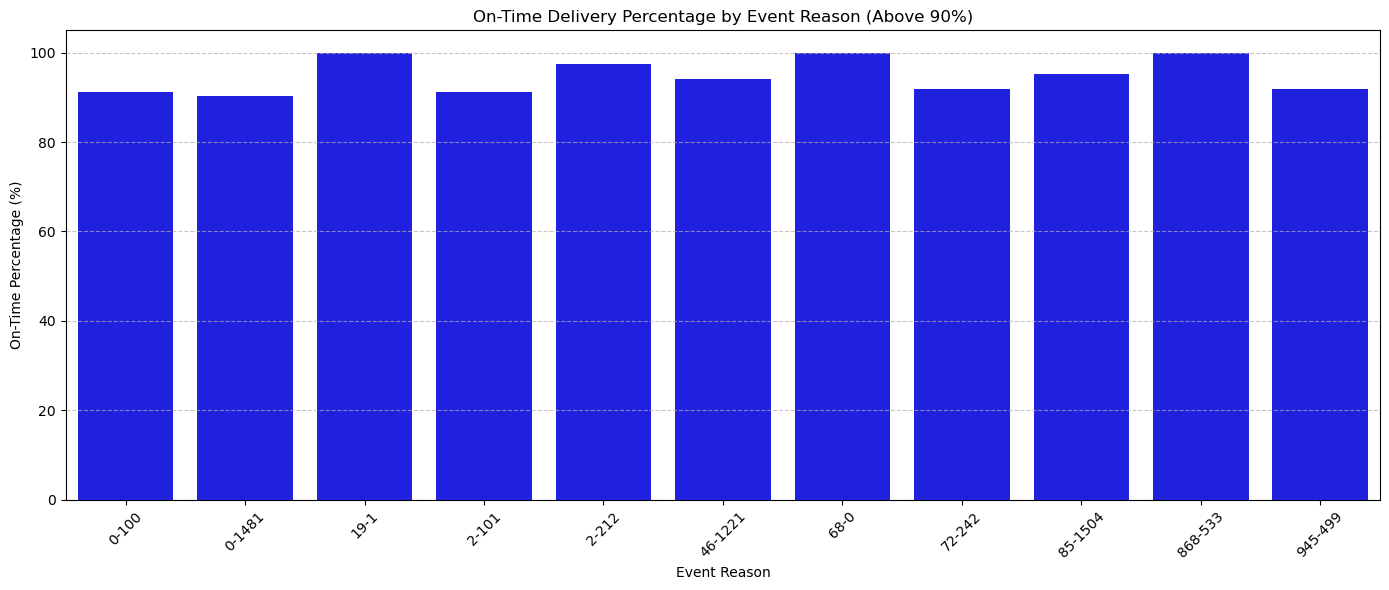

In [262]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage
on_time_percentage = df_unique.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Filter for event reasons with on-time percentage greater than 90%
on_time_above_90 = on_time_percentage[on_time_percentage > 90]

# Create a bar plot with conditional coloring
plt.figure(figsize=(14, 6))

# Determine colors based on the condition (above or below 90%)
colors = ['blue' if x > 50 else 'red' for x in on_time_above_90.values]

# Plot the bar plot with the specified colors
sns.barplot(x=on_time_above_90.index, y=on_time_above_90.values, palette=colors)

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('On-Time Percentage (%)')
plt.title('On-Time Delivery Percentage by Event Reason (Above 90%)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

We notice that the event reasons with the best on_time delivery percentages are:
- 0-100: Data creation	preadvice data
- 0-1481: Data creation	48h processing
- 2-101: Inbound Key account check
- 2-212: Inbound sorted as Business-Small Parcel - k. ac
- 19-1: P&S/P&R collection problem	traffic problems
- 46-1221: 	Check scan	Outbound sorting
- 68-0: Unloaded from GLS transport unit	normal
- 72-242: Relabelled 1D to 2D-UniCode
- 85-1504: Information	ATTENTION: TESTING OF SIGNATURE SERVICE
- 868-533: AddOnLiability Amount	AOL amount added
- 945-499: Labeltype	Mini or Maxi label

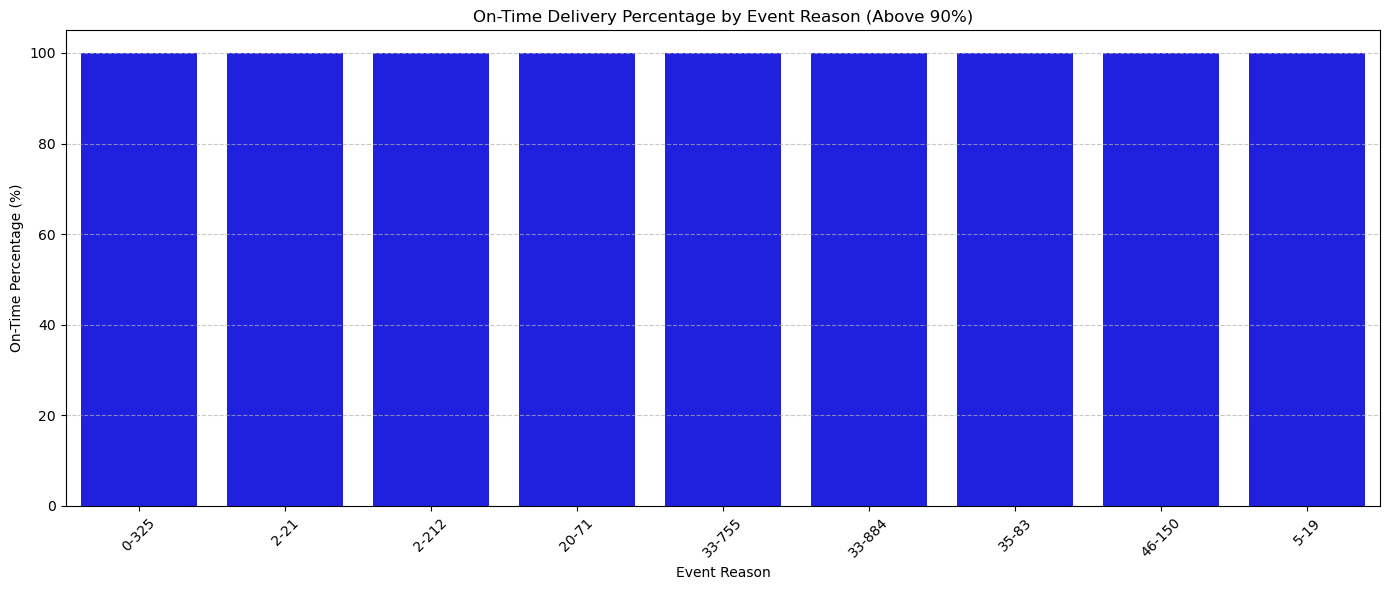

In [108]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage for depot 120
on_time_percentage = df_120.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Filter for event reasons with on-time percentage greater than 90%
on_time_above_90 = on_time_percentage[on_time_percentage > 90]


# Create a bar plot with conditional coloring
plt.figure(figsize=(14, 6))

# Determine colors based on the condition (above or below 90%)
colors = ['blue' if x > 50 else 'red' for x in on_time_above_90.values]

# Plot the bar plot with the specified colors
sns.barplot(x=on_time_above_90.index, y=on_time_above_90.values, palette=colors)

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('On-Time Percentage (%)')
plt.title('On-Time Delivery Percentage by Event Reason (Above 90%)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# LOOK HERE, WHY 100
EVENT_REASONS for DEPOT 120 that have 100% percentage delivery on time
0-325     - Data creation	Max weight exceeded 
2-21      - Inbound	total damage
2-212     - Inbound	sorted as Business-Small Parcel - k. ac
20-71     - P&S/P&R request cancelled	no goods to pick up
33-755    - Change completed for	Product
33-884    - Change completed for	Update 1D by initial data
35-83     - Stored	awaiting consignee pick up
46-150    - Check scan	documents complete
5-19      - Returned to shipper	Excluded by GLS Terms & Conditions

In [ ]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage for depot 120
on_time_percentage = df_120.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Filter for event reasons with on-time percentage greater than 90%
on_time_above_90 = on_time_percentage[on_time_percentage = 100]

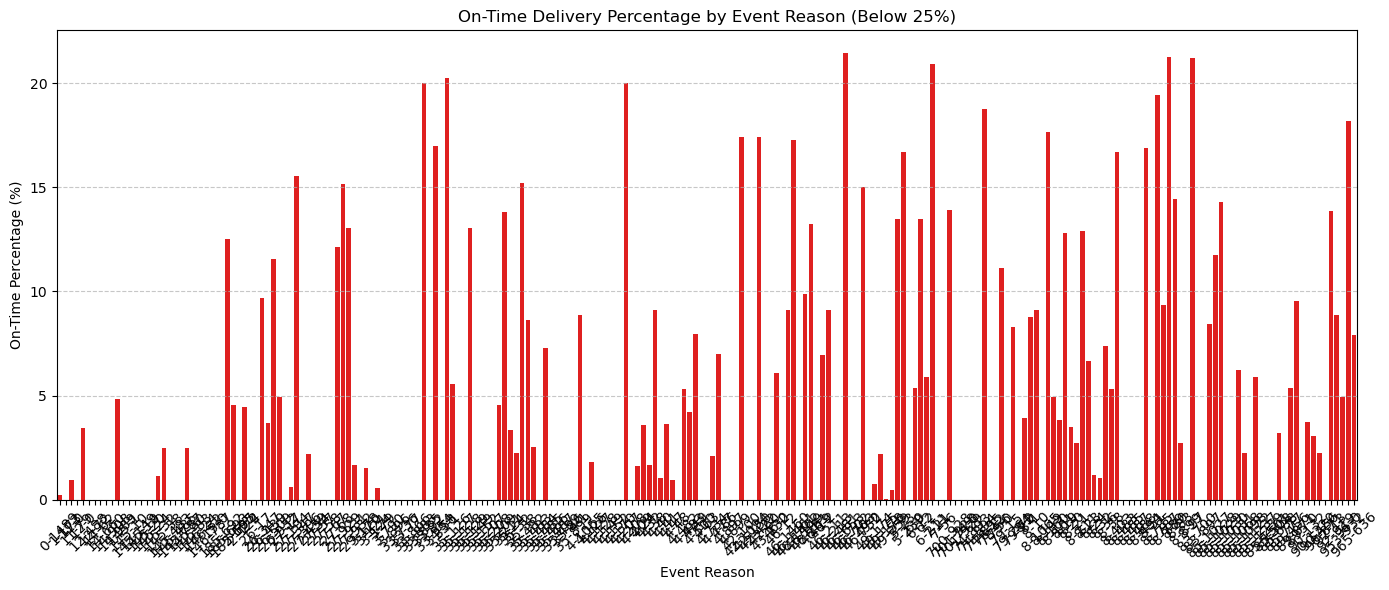

In [263]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage
on_time_percentage = df_unique.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Filter for event reasons with on-time percentage less than 25%
on_time_below_25 = on_time_percentage[on_time_percentage < 25]

# Create a bar plot with conditional coloring
plt.figure(figsize=(14, 6))

# Determine colors based on the condition (above or below 25%)
colors = ['red' if x < 25 else 'blue' for x in on_time_below_25.values]

# Plot the bar plot with the specified colors
sns.barplot(x=on_time_below_25.index, y=on_time_below_25.values, palette=colors)

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('On-Time Percentage (%)')
plt.title('On-Time Delivery Percentage by Event Reason (Below 25%)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

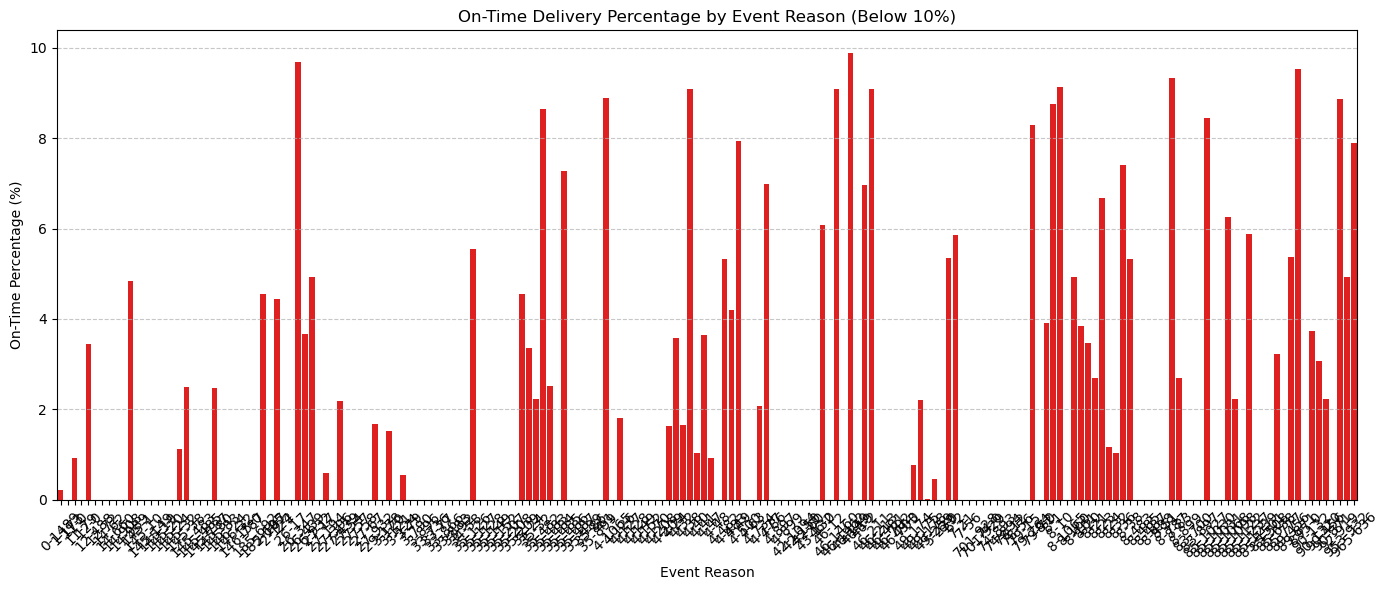

In [264]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage
on_time_percentage = df_unique.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Filter for event reasons with on-time percentage less than 10%
on_time_below_10 = on_time_percentage[on_time_percentage < 10]

# Create a bar plot with conditional coloring
plt.figure(figsize=(14, 6))

# All bars will be red, as we only include percentages below 10%
colors = ['red' for _ in on_time_below_10.values]

# Plot the bar plot with the specified colors
sns.barplot(x=on_time_below_10.index, y=on_time_below_10.values, palette=colors)

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('On-Time Percentage (%)')
plt.title('On-Time Delivery Percentage by Event Reason (Below 10%)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

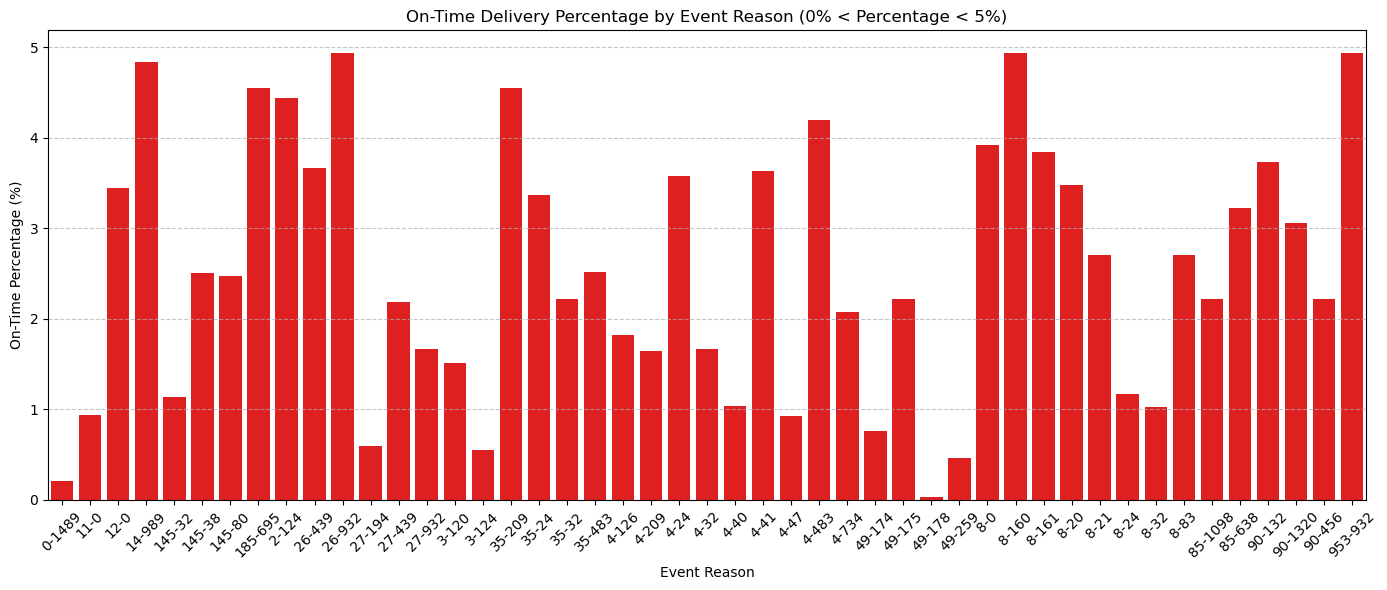

In [265]:
# Step 2: Group by 'EVENT_REASON' and calculate on-time percentage
on_time_percentage = df_unique.groupby('EVENT_REASON')['ON_TIME'].mean() * 100

# Step 3: Filter for event reasons with on-time percentage greater than 0% and less than 5%
on_time_below_5_above_0 = on_time_percentage[(on_time_percentage > 0) & (on_time_percentage < 5)]

# Create a bar plot with conditional coloring
plt.figure(figsize=(14, 6))

# All bars will be red, as we only include percentages between 0% and 5%
colors = ['red' for _ in on_time_below_5_above_0.values]

# Plot the bar plot with the specified colors
sns.barplot(x=on_time_below_5_above_0.index, y=on_time_below_5_above_0.values, palette=colors)

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('On-Time Percentage (%)')
plt.title('On-Time Delivery Percentage by Event Reason (0% < Percentage < 5%)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

We notice that the worst rating event codes aka less than 1% true ratings are 
- 0-1489: Data creation	Loaded into transport unit
- 27-194: Shipment unlocked	Return to shipper
- 3-124: Delivered	GLS ParcelShop
- 49-178: Parcel under investigation	after outbound
- 49-259: Parcel under investigation	after warehouse scan
- 8-24: Parcel in Warehouse	refused
- 8-32: Parcel in Warehouse	incorrect address

# Analyzing event reasons with df_unique

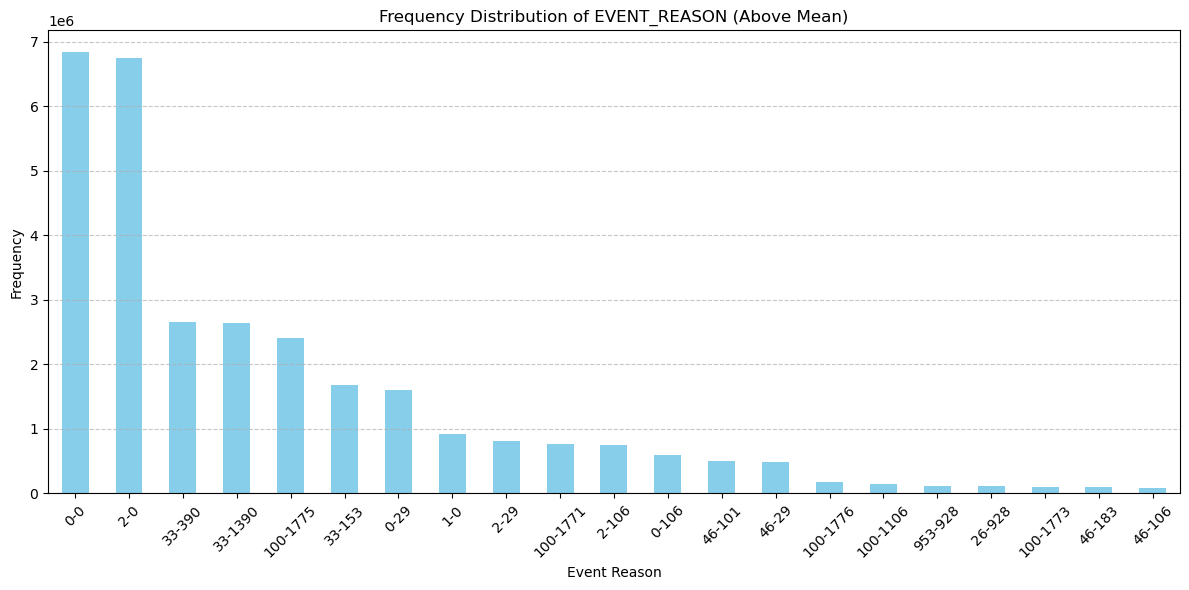

In [266]:
# Step 1: Calculate frequency distribution of EVENT_REASON
event_reason_counts = df_unique['EVENT_REASON'].value_counts()

# Step 2: Calculate mean frequency
mean_frequency = event_reason_counts.mean()

# Step 3: Filter event reasons with frequency higher than the mean
filtered_event_reasons = event_reason_counts[event_reason_counts > mean_frequency]

# Step 4: Plot the filtered frequency distribution
plt.figure(figsize=(12, 6))
filtered_event_reasons.plot(kind='bar', color='skyblue')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of EVENT_REASON (Above Mean)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Similar results to df
The most used events are:
- 0-0: Data creation	normal
- 2-0: Inbound	normal
- 33-390: Change completed for	Volume weight
- 33-1390: Change completed for	Volume weight GER
- 100-1775: Volume measurement	No exceeding
- 33-153:Change completed for	Weight
- 0-29: Data creation	sorted as Business-Small Parcel
- 1-0: Outbound	normal
- 2-29: Inbound	sorted as Business-Small Parcel

In [268]:
#Filter df_unique to keep only rows where VOLUME is missing (NaN)
df_novolume = df_unique[df_unique['VOLUME'].isna()]

In [269]:
#Further filter to keep only rows where DESTINATION_DEPOT_ID is 120
df_novolume_120 = df_novolume[df_novolume['DESTINATION_DEPOT_ID'] == 120]

In [270]:
#Further filter to exclude rows where DESTINATION_DEPOT_ID is 120
df_novolume_other = df_novolume[df_novolume['DESTINATION_DEPOT_ID'] != 120]

In [18]:
#Filter df_unique to keep only rows where DESTINATION_DEPOT_ID is 120
df_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

In [272]:
#Filter df_unique to exclude rows where DESTINATION_DEPOT_ID is 120
df_other = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]

In [273]:
warnings.filterwarnings('ignore')

In [274]:
# Step 1: Ensure 'SCAN_DEPOT_ID' and 'EVENT_REASON' are of the correct type
df_120['SCAN_DEPOT_ID'] = df_120['SCAN_DEPOT_ID'].astype(str)  # Convert to string if not already
df_120['EVENT_REASON'] = df_120['EVENT_REASON'].astype(str)  # Convert to string if not already

# Step 2: Check data
print(df_120[['SCAN_DEPOT_ID', 'EVENT_REASON']].head())

         SCAN_DEPOT_ID EVENT_REASON
49404272           100          0-0
29190494           100         2-29
6209153             12          2-0
56377685           120       33-153
19428498            12        46-29


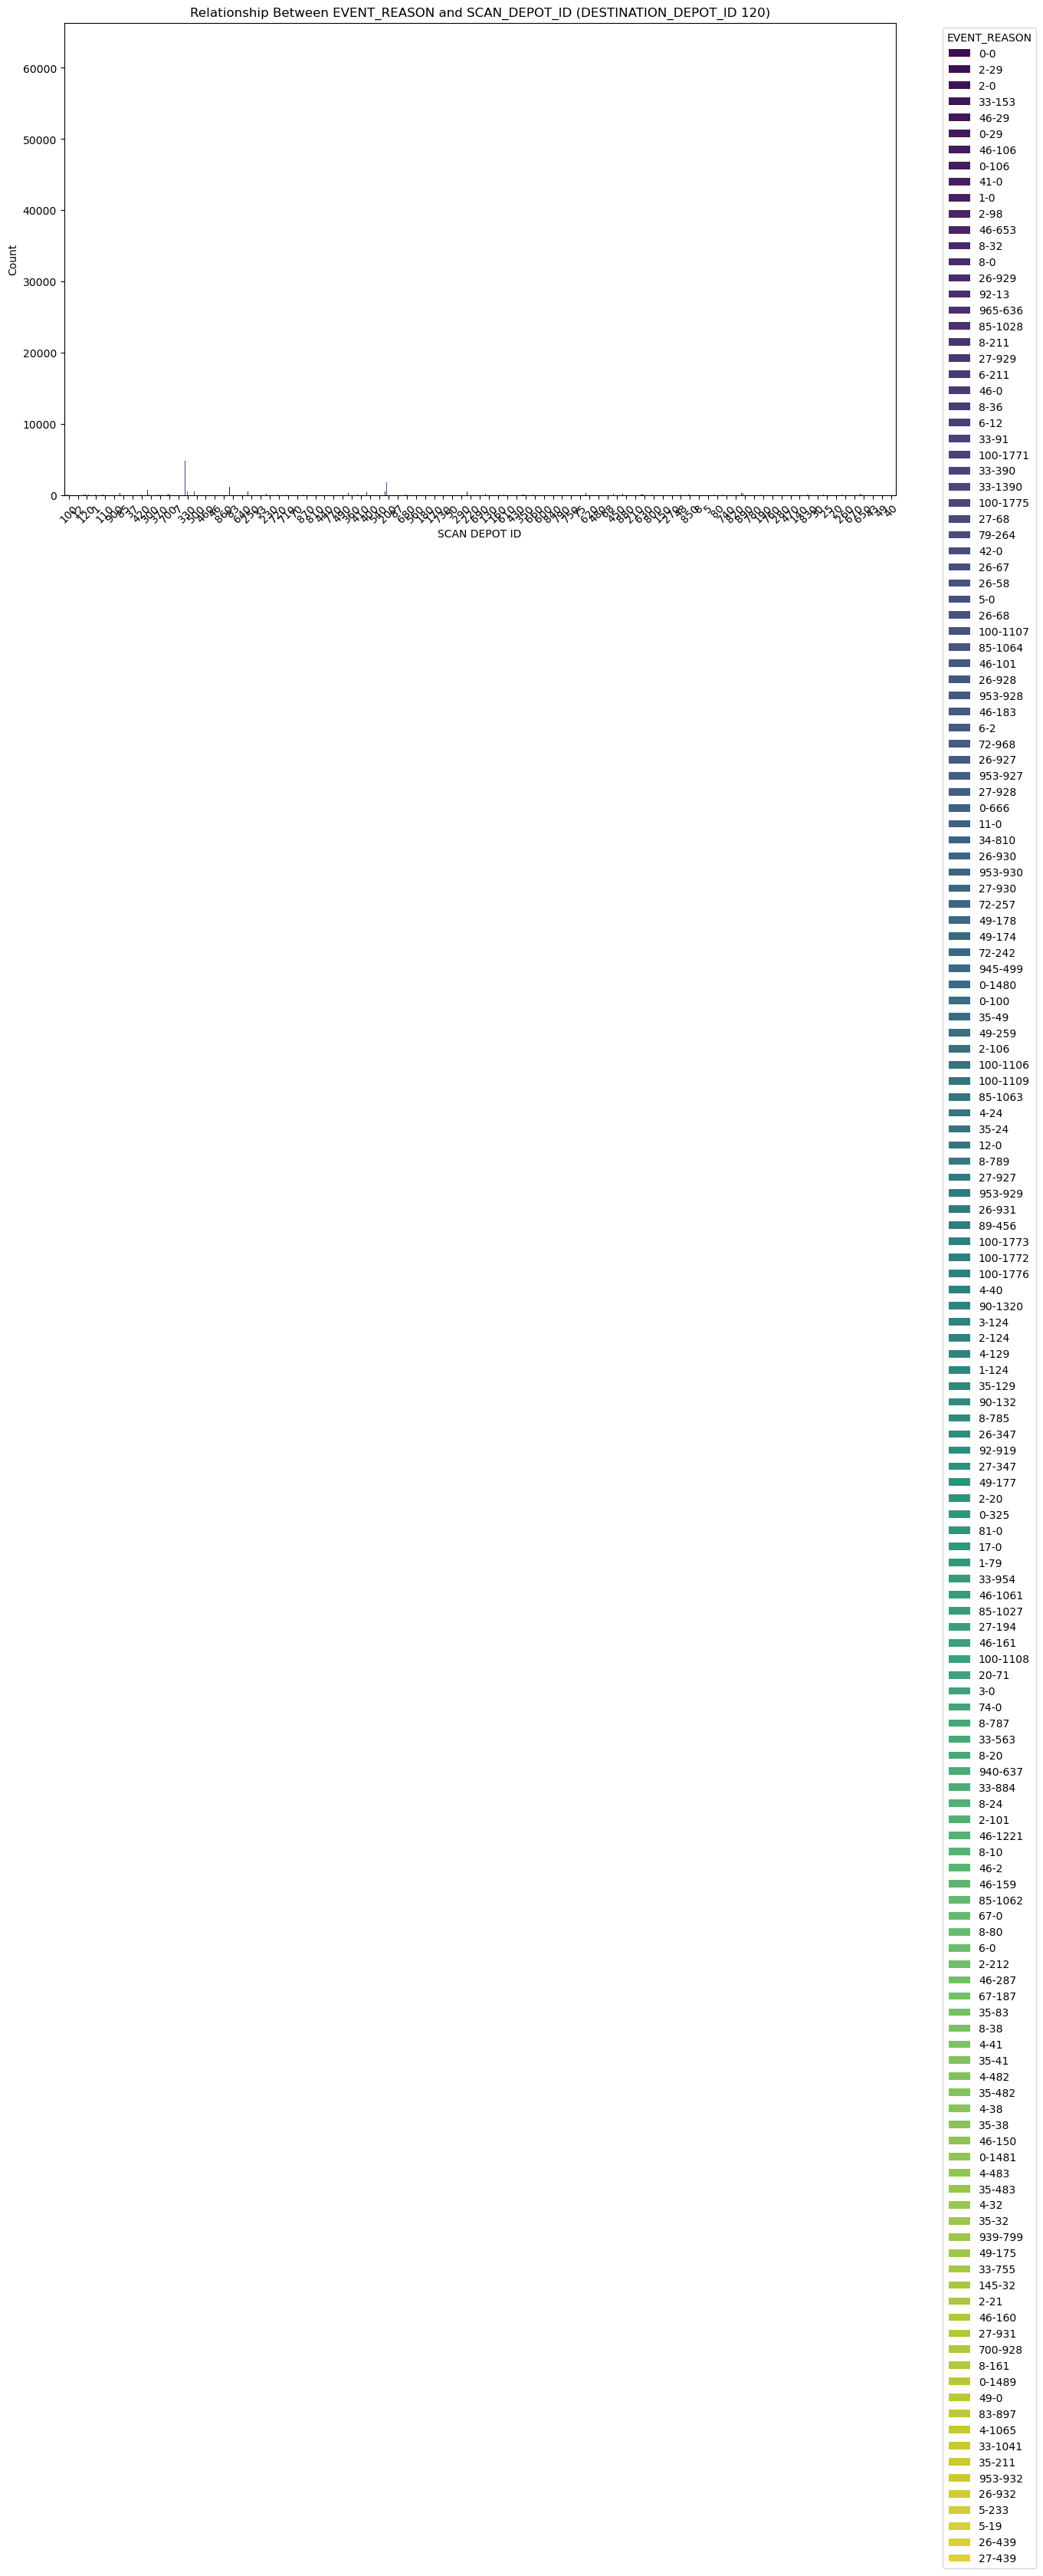

In [275]:
#Create a count plot showing the relationship between EVENT_REASON and SCAN_DEPOT_ID
plt.figure(figsize=(14, 8))
sns.countplot(data=df_120, x='SCAN_DEPOT_ID', hue='EVENT_REASON', palette='viridis')

# Customize the plot
plt.xlabel('SCAN DEPOT ID')
plt.ylabel('Count')
plt.title('Relationship Between EVENT_REASON and SCAN_DEPOT_ID (DESTINATION_DEPOT_ID 120)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='EVENT_REASON', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Corrected function name
plt.show()

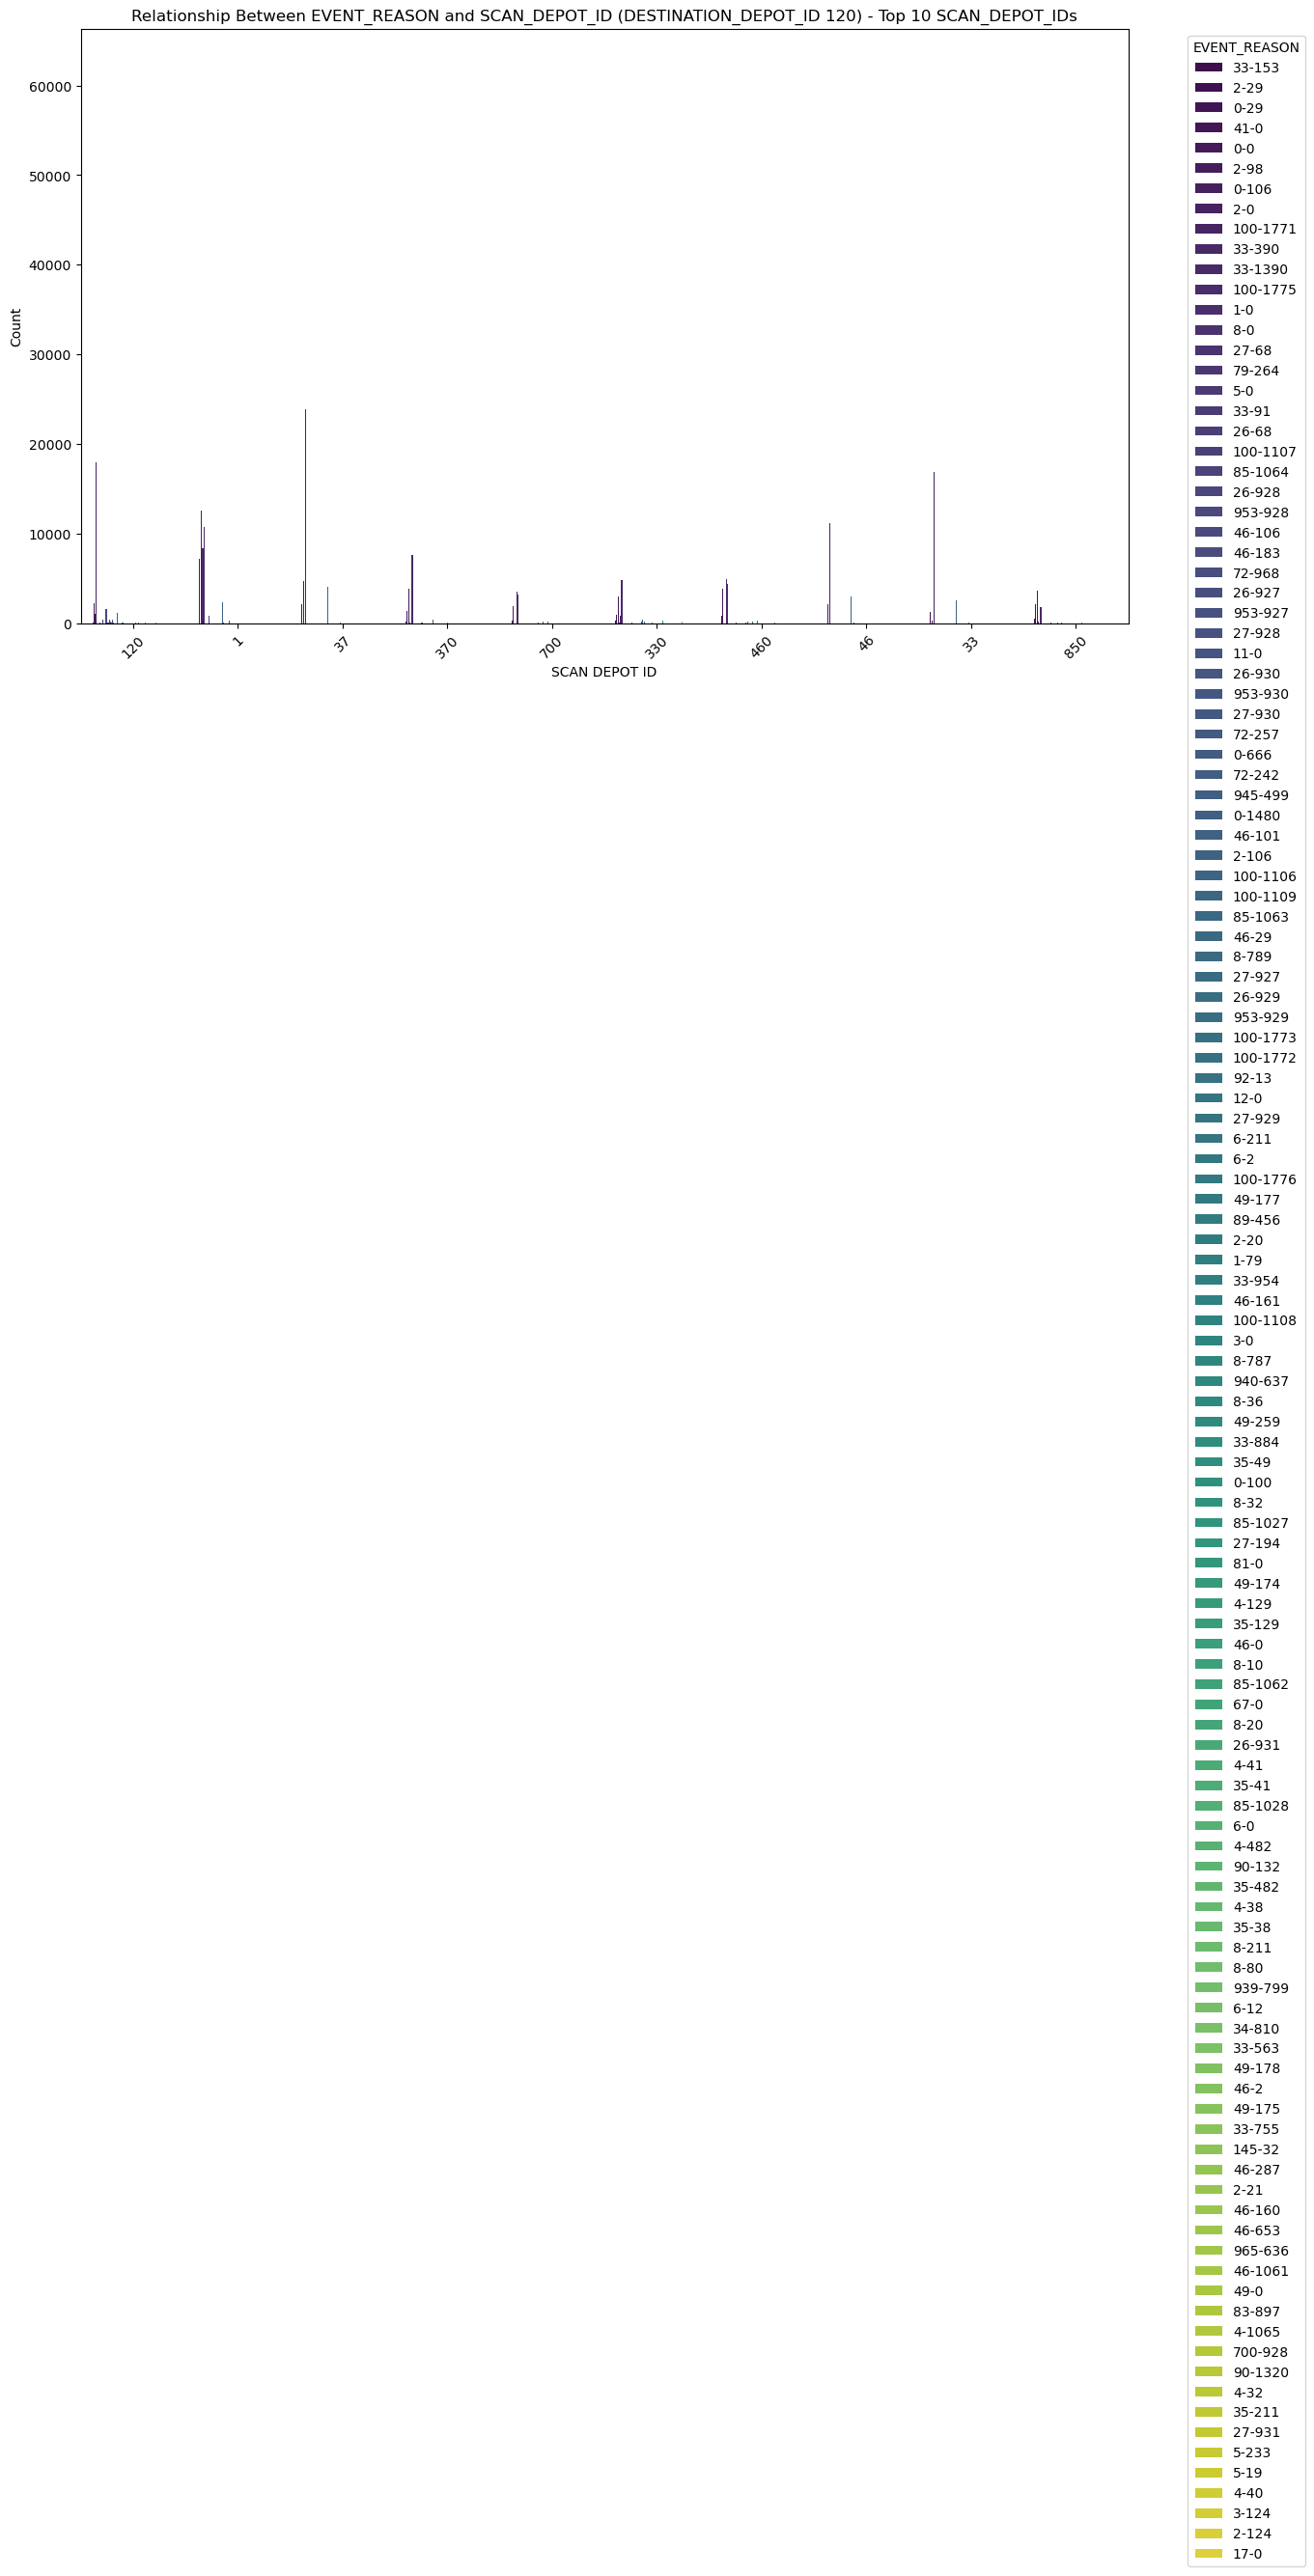

In [298]:
#Calculate the count of each SCAN_DEPOT_ID and get the top 10
top_10_scan_depot_ids = df_120['SCAN_DEPOT_ID'].value_counts().nlargest(10).index

#Filter the DataFrame to include only the top 10 SCAN_DEPOT_IDs
df_top_10 = df_120[df_120['SCAN_DEPOT_ID'].isin(top_10_scan_depot_ids)]

# Step 4: Create a count plot showing the relationship between EVENT_REASON and SCAN_DEPOT_ID for the top 10
plt.figure(figsize=(14, 8))
sns.countplot(data=df_top_10, x='SCAN_DEPOT_ID', hue='EVENT_REASON', palette='viridis')

# Customize the plot
plt.xlabel('SCAN DEPOT ID')
plt.ylabel('Count')
plt.title('Relationship Between EVENT_REASON and SCAN_DEPOT_ID (DESTINATION_DEPOT_ID 120) - Top 10 SCAN_DEPOT_IDs')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='EVENT_REASON', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

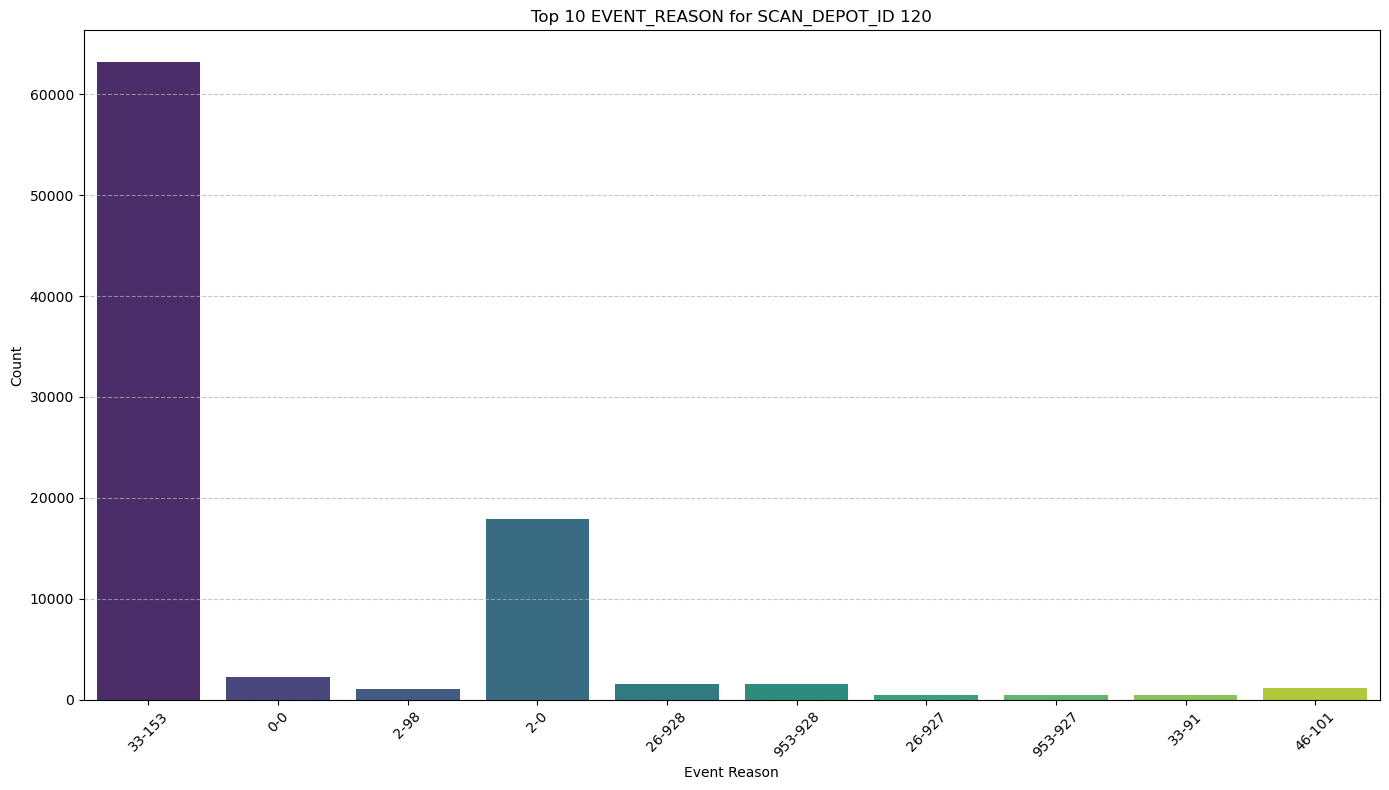

In [300]:
# Step 1: Filter the DataFrame to include only rows where SCAN_DEPOT_ID is 120
df_120_filtered = df_120[df_120['SCAN_DEPOT_ID'] == '120']

# Step 2: Calculate the count of each EVENT_REASON for SCAN_DEPOT_ID 120
event_reason_counts_120 = df_120_filtered['EVENT_REASON'].value_counts().reset_index()
event_reason_counts_120.columns = ['EVENT_REASON', 'Frequency']

# Step 3: Get the top 10 EVENT_REASON values for SCAN_DEPOT_ID 120
top_10_event_reasons_120 = event_reason_counts_120.nlargest(10, 'Frequency')

# Step 4: Create a count plot showing the relationship between EVENT_REASON and SCAN_DEPOT_ID 120
plt.figure(figsize=(14, 8))
sns.countplot(data=df_120_filtered[df_120_filtered['EVENT_REASON'].isin(top_10_event_reasons_120['EVENT_REASON'])],
              x='EVENT_REASON', palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Count')
plt.title('Top 10 EVENT_REASON for SCAN_DEPOT_ID 120')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

For destination depot 120, the most recurrent event_code is 33-153 which is ' Change completed for Weight' so we should look more into weight and this event reason for depot 120. And 2-0 which is Inbound normal.

In [84]:
# Step 1: Group by EVENT_REASON and calculate counts
grouped = df_120.groupby('EVENT_REASON').agg(
    total_deliveries=('ON_TIME', 'size'),
    on_time_deliveries=('ON_TIME', 'sum')
).reset_index()

# Step 2: Calculate the percentage of ON_TIME deliveries
grouped['percentage_on_time'] = (grouped['on_time_deliveries'] / grouped['total_deliveries']) * 100

# Print the results
print(grouped)

    EVENT_REASON  total_deliveries  on_time_deliveries  percentage_on_time
0            0-0            100365               73008           72.742490
1          0-100               498                 382           76.706827
2          0-106              8007                5608           70.038716
3         0-1480               162                 124           76.543210
4         0-1481                30                   9           30.000000
..           ...               ...                 ...                 ...
152      953-928              1543                 870           56.383668
153      953-929                55                  27           49.090909
154      953-930               411                 232           56.447689
155      953-932                 1                   0            0.000000
156      965-636                10                   1           10.000000

[157 rows x 4 columns]


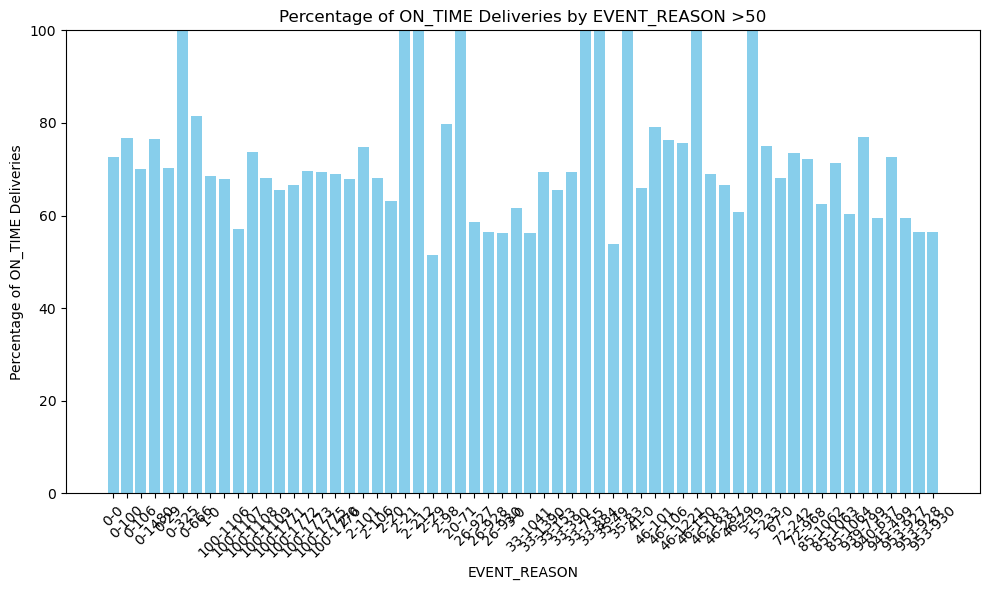

In [88]:
# Step 3: Filter the DataFrame to include only rows with percentage > 50%
filtered_grouped = grouped[grouped['percentage_on_time'] > 50]

# Step 4: Plotting
plt.figure(figsize=(10, 6))
plt.bar(filtered_grouped['EVENT_REASON'].astype(str), filtered_grouped['percentage_on_time'], color='skyblue')
plt.xlabel('EVENT_REASON')
plt.ylabel('Percentage of ON_TIME Deliveries')
plt.title('Percentage of ON_TIME Deliveries by EVENT_REASON >50')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization

# Show the plot
plt.tight_layout()
plt.show()

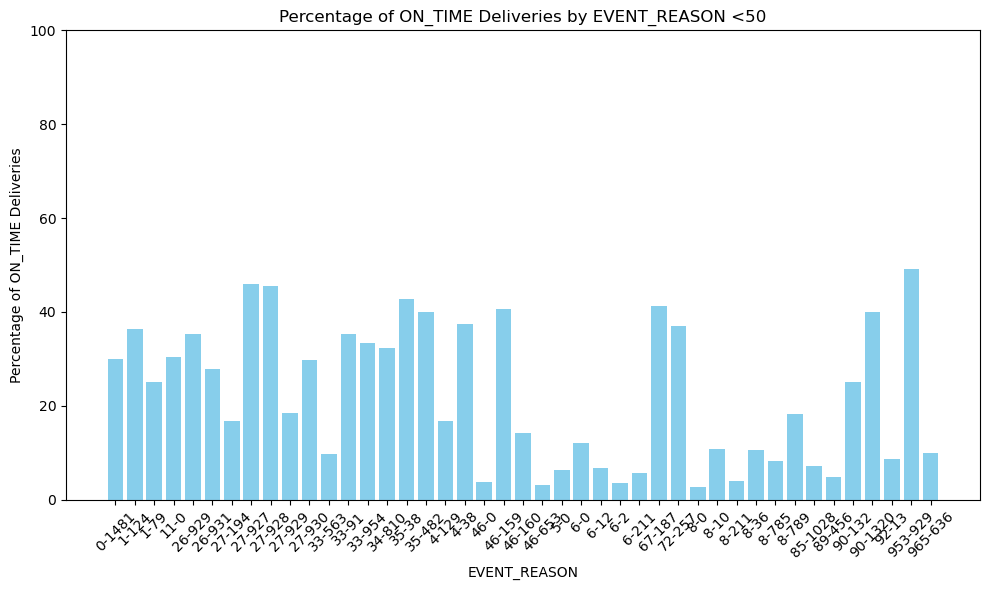

In [92]:
# Step 3: Filter the DataFrame to include only rows with percentage <50%
filtered_low_grouped = grouped[
    (grouped['percentage_on_time'] > 0) & (grouped['percentage_on_time'] < 50)
]

# Step 4: Plotting
plt.figure(figsize=(10, 6))
plt.bar(filtered_low_grouped['EVENT_REASON'].astype(str), filtered_low_grouped['percentage_on_time'], color='skyblue')
plt.xlabel('EVENT_REASON')
plt.ylabel('Percentage of ON_TIME Deliveries')
plt.title('Percentage of ON_TIME Deliveries by EVENT_REASON <50')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.ylim(0, 100)  # Set y-axis limit to 100% for better visualization

# Show the plot
plt.tight_layout()
plt.show()

In [94]:
# Step 1: Sort by percentage_on_time in ascending order
sorted_low_grouped = filtered_low_grouped.sort_values(by='percentage_on_time')

# Step 2: Select the top 10 worst-performing EVENT_REASON categories
top_10_worst = sorted_low_grouped.head(10)

# Print the result
print(top_10_worst[['EVENT_REASON', 'percentage_on_time']])

    EVENT_REASON  percentage_on_time
123          8-0            2.631579
101       46-653            3.125000
113          6-2            3.524804
88          46-0            3.773585
127        8-211            4.000000
143       89-456            4.878049
114        6-211            5.797101
108          5-0            6.250000
112         6-12            6.666667
139      85-1028            7.142857


- 8-0: Parcel in Warehouse normal
- 46-653: Check scan INB not picked from belt
- 6-2: Forwarded sorting error
- 46-0: Check scan normal
- 8-211: Parcel in Warehouse	Redirected   
- 89-456: Shipper contacted	via E-Mail
- 6-211: 	Forwarded	Redirected
- 5-0: Returned to shipper	normal
- 6-12: Forwarded	misrouted
- 85-1028: Information	Delivery detected

## BUT, for the entire dataset we found that
We notice that the worst rating event codes aka less than 1% true ratings are
- 0-1489: Data creation Loaded into transport unit
- 27-194: Shipment unlocked Return to shipper
- 3-124: Delivered GLS ParcelShop
- 49-178: Parcel under investigation after outbound
- 49-259: Parcel under investigation after warehouse scan
- 8-24: Parcel in Warehouse refused
- 8-32: Parcel in Warehouse incorrect address

## Different event reasons

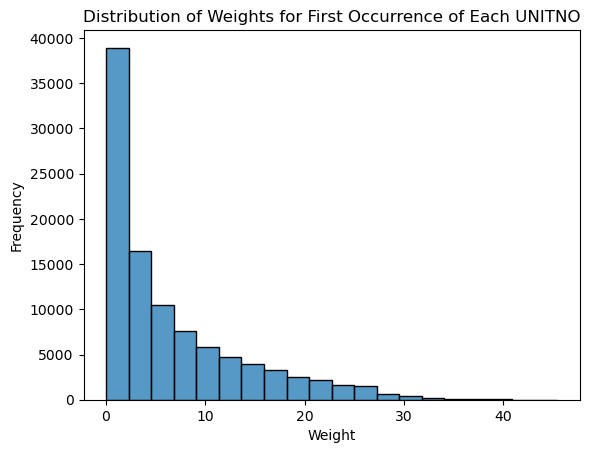

In [311]:
# Step 1: Filter rows where DESTINATION_DEPOT_ID is 120
filtered_df = df[df['DESTINATION_DEPOT_ID'] == 120]

# Step 2: Identify the first occurrence of each UNITNO based on earliest SCAN_DATETIME
# First, ensure SCAN_DATETIME is in datetime format
filtered_df['SCAN_DATETIME'] = pd.to_datetime(filtered_df['SCAN_DATETIME'])

# Sort by UNITNO and SCAN_DATETIME to ensure earliest comes first
sorted_df = filtered_df.sort_values(by=['UNITNO', 'SCAN_DATETIME'])

# Drop duplicates, keeping the first occurrence of each UNITNO
first_occurrence_df = sorted_df.drop_duplicates(subset='UNITNO', keep='first')

# Step 3: Analyze weight distributions
weight_summary = first_occurrence_df['WEIGHT'].describe()

# For visualization, you might use something like:
import matplotlib.pyplot as plt
import seaborn as sns

# Example of a histogram
sns.histplot(first_occurrence_df['WEIGHT'], bins=20)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weights for First Occurrence of Each UNITNO')
plt.show()

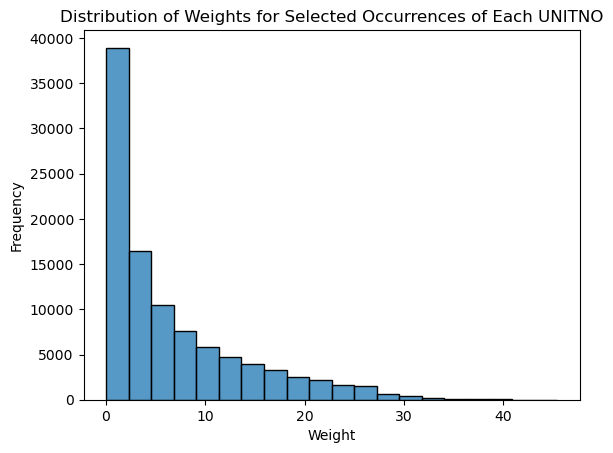

In [315]:
# Step 1: Filter rows where DESTINATION_DEPOT_ID is 120
filtered_df = df[df['DESTINATION_DEPOT_ID'] == 120]

# Step 2: Ensure SCAN_DATETIME is in datetime format
filtered_df['SCAN_DATETIME'] = pd.to_datetime(filtered_df['SCAN_DATETIME'])

# Step 3: Sort by UNITNO, EVENT_REASON condition, and SCAN_DATETIME
# Prioritize "33-153" in EVENT_REASON and sort by SCAN_DATETIME
filtered_df['priority'] = (filtered_df['EVENT_REASON'] == "33-153").astype(int)
sorted_df = filtered_df.sort_values(by=['UNITNO', 'priority', 'SCAN_DATETIME'], ascending=[True, False, True])

# Step 4: Drop duplicates, keeping the first occurrence of each UNITNO
first_occurrence_df = sorted_df.drop_duplicates(subset='UNITNO', keep='first')

# Example of a histogram
sns.histplot(first_occurrence_df['WEIGHT'], bins=20)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weights for Selected Occurrences of Each UNITNO')
plt.show()

Looking at the first scan of the parcel or at the scan when the event code shows a change of weight does not change the distribution of weights. 

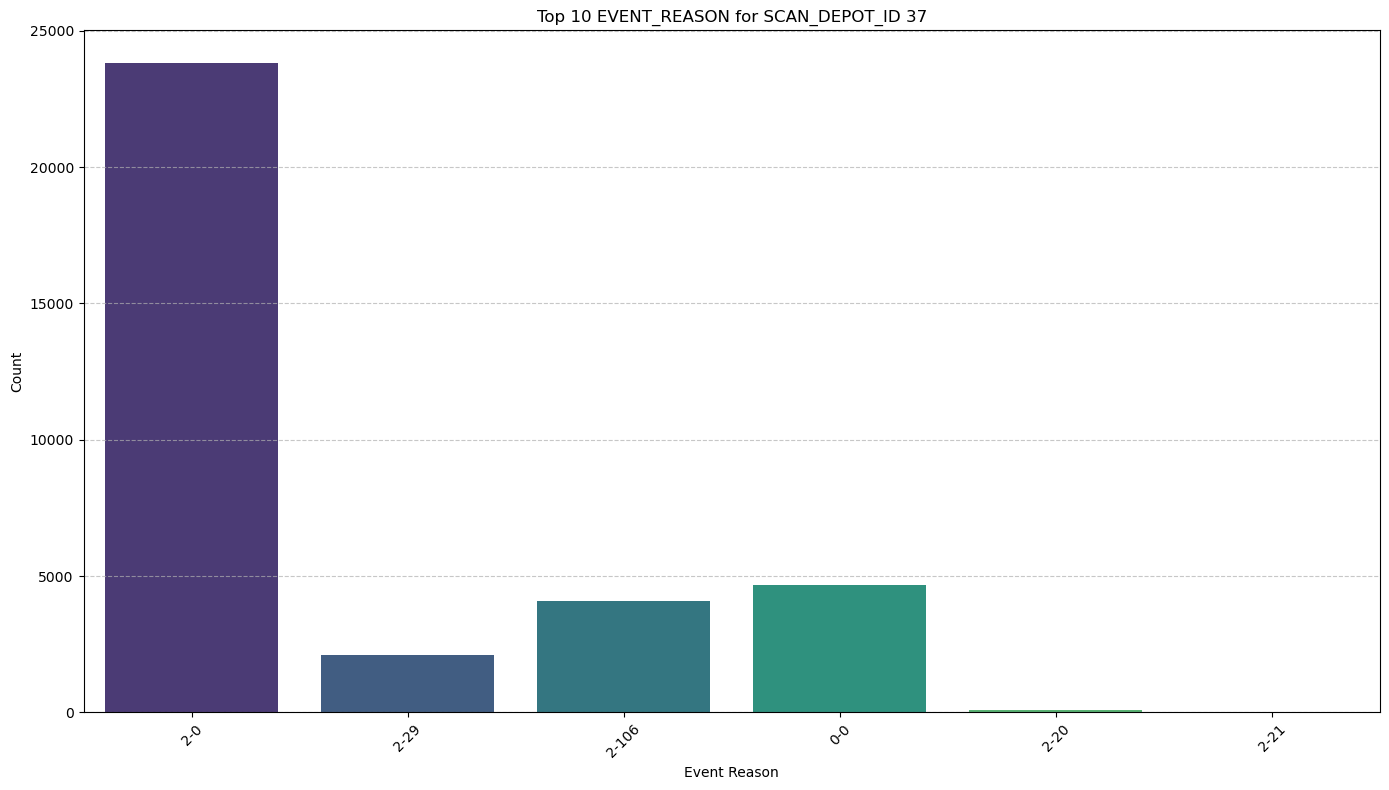

In [302]:
# Step 1: Filter the DataFrame to include only rows where SCAN_DEPOT_ID is 37
df_120_filtered = df_120[df_120['SCAN_DEPOT_ID'] == '37']

# Step 2: Calculate the count of each EVENT_REASON for SCAN_DEPOT_ID 120
event_reason_counts_120 = df_120_filtered['EVENT_REASON'].value_counts().reset_index()
event_reason_counts_120.columns = ['EVENT_REASON', 'Frequency']

# Step 3: Get the top 10 EVENT_REASON values for SCAN_DEPOT_ID 120
top_10_event_reasons_120 = event_reason_counts_120.nlargest(10, 'Frequency')

# Step 4: Create a count plot showing the relationship between EVENT_REASON and SCAN_DEPOT_ID 37
plt.figure(figsize=(14, 8))
sns.countplot(data=df_120_filtered[df_120_filtered['EVENT_REASON'].isin(top_10_event_reasons_120['EVENT_REASON'])],
              x='EVENT_REASON', palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Count')
plt.title('Top 10 EVENT_REASON for SCAN_DEPOT_ID 37')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

For depot 37, most recurrent event codes are 2-0 (Inbound normal), 2-29 (Inbound sorted as Business-Small Parcel), 2-106 (Inbound Non conveyable / Manually sorted) and 0-0 (Data creation normal)

## For depot 1

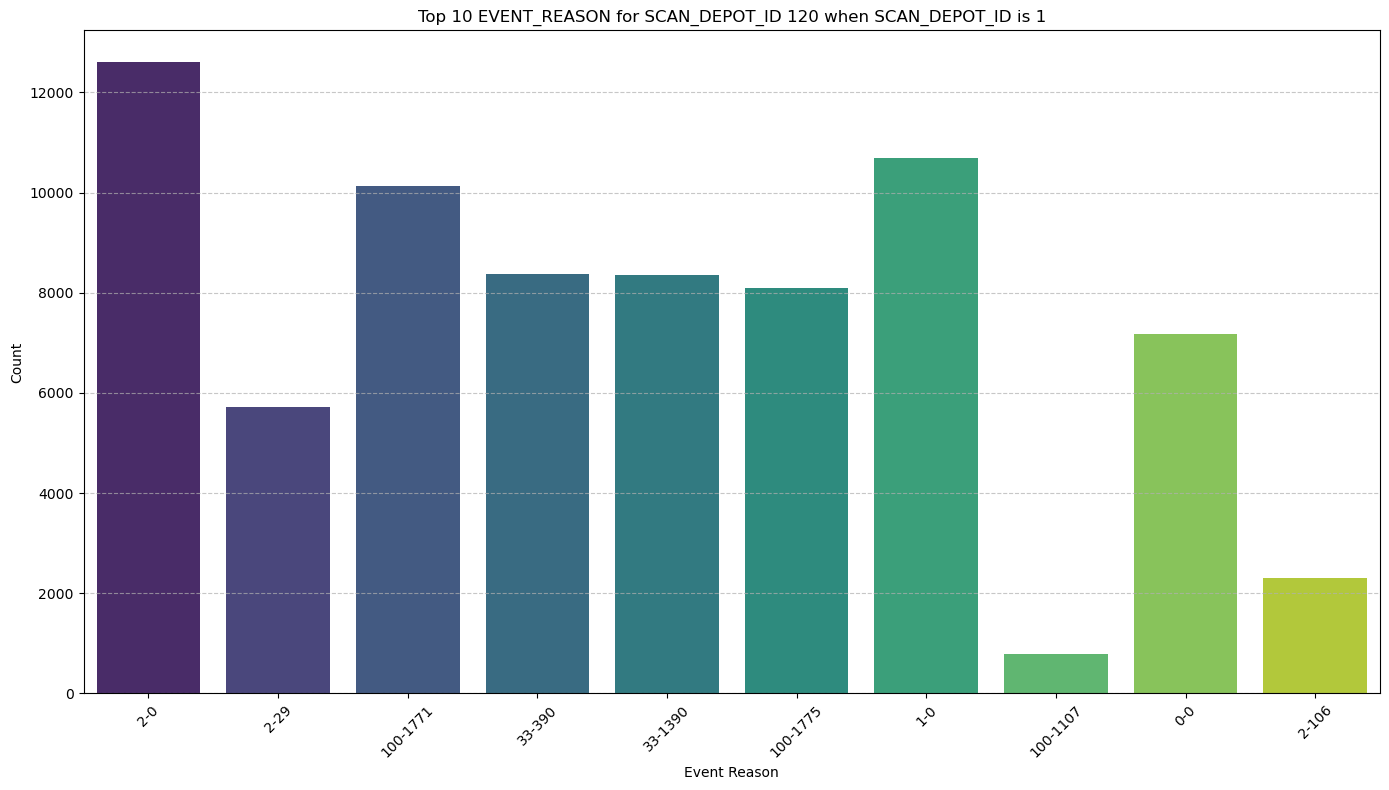

In [308]:
# Step 1: Filter the DataFrame to include only rows where SCAN_DEPOT_ID is 1
df_120_filtered = df_120[df_120['SCAN_DEPOT_ID'] == '1']

# Step 2: Calculate the count of each EVENT_REASON for SCAN_DEPOT_ID 120
event_reason_counts_120 = df_120_filtered['EVENT_REASON'].value_counts().reset_index()
event_reason_counts_120.columns = ['EVENT_REASON', 'Frequency']

# Step 3: Get the top 10 EVENT_REASON values for SCAN_DEPOT_ID 120
top_10_event_reasons_120 = event_reason_counts_120.nlargest(10, 'Frequency')

# Step 4: Create a count plot showing the relationship between EVENT_REASON and SCAN_DEPOT_ID 120
plt.figure(figsize=(14, 8))
sns.countplot(data=df_120_filtered[df_120_filtered['EVENT_REASON'].isin(top_10_event_reasons_120['EVENT_REASON'])],
              x='EVENT_REASON', palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Count')
plt.title('Top 10 EVENT_REASON for SCAN_DEPOT_ID 120 when SCAN_DEPOT_ID is 1')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

Only focusing on Scan_Depot_ID 1 when checking destination_depot_id 120, the event codes that are most used change and we get the basic ones instead of the weight change. 

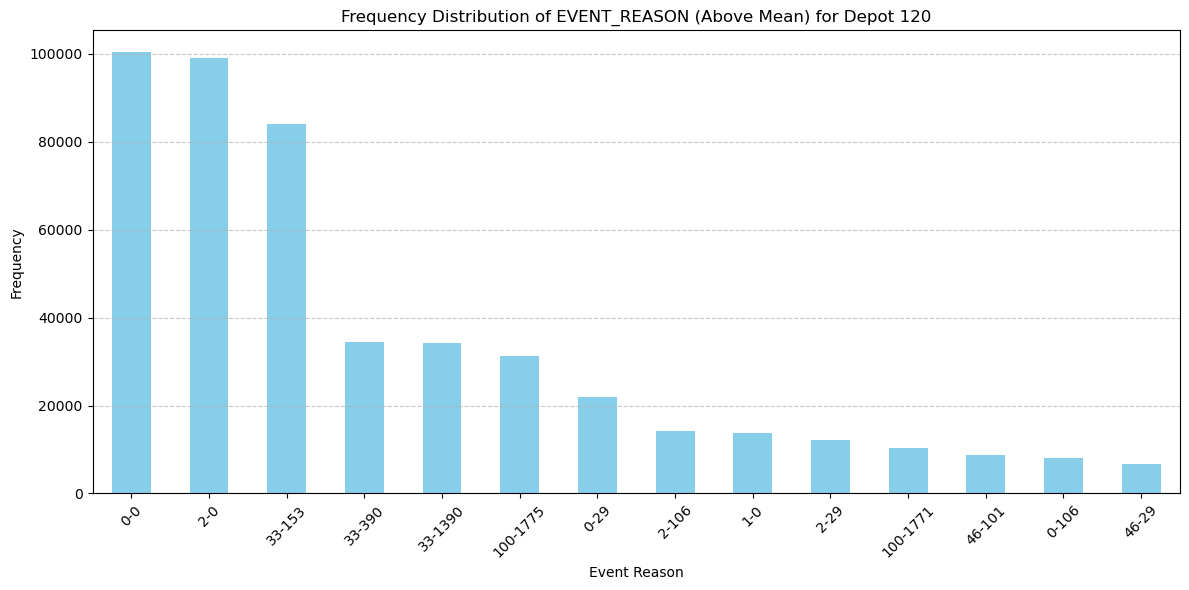

In [320]:
# Step 1: Calculate frequency distribution of EVENT_REASON
event_reason_counts = df_120['EVENT_REASON'].value_counts()

# Step 2: Calculate mean frequency
mean_frequency = event_reason_counts.mean()

# Step 3: Filter event reasons with frequency higher than the mean
filtered_event_reasons = event_reason_counts[event_reason_counts > mean_frequency]

# Step 4: Plot the filtered frequency distribution
plt.figure(figsize=(12, 6))
filtered_event_reasons.plot(kind='bar', color='skyblue')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of EVENT_REASON (Above Mean) for Depot 120')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

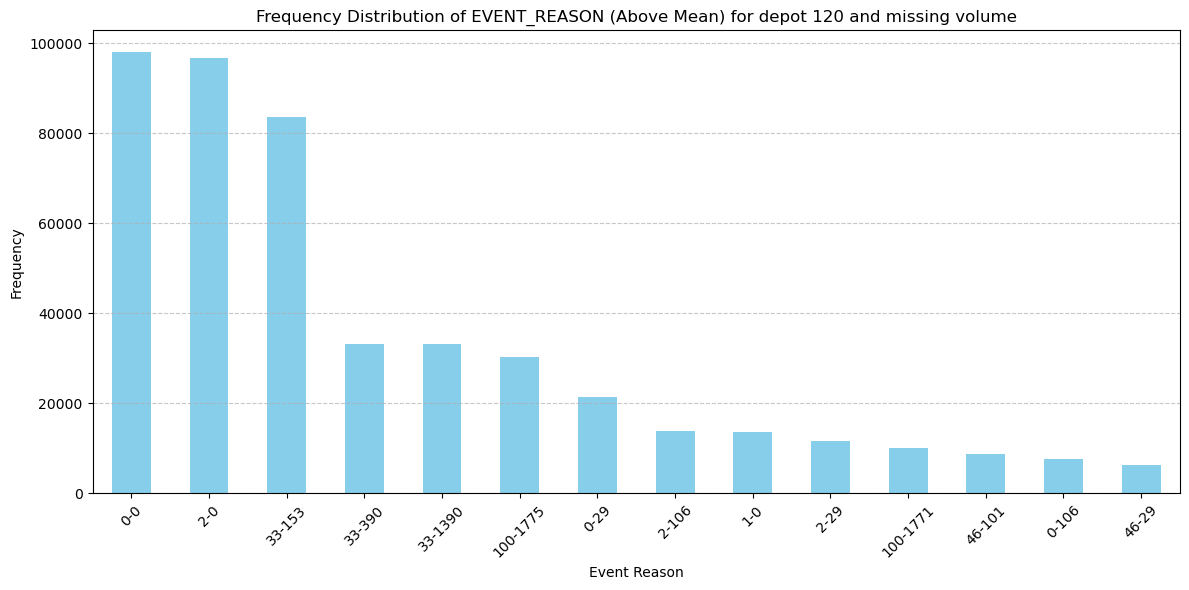

In [322]:
# Step 1: Calculate frequency distribution of EVENT_REASON
event_reason_counts = df_novolume_120['EVENT_REASON'].value_counts()

# Step 2: Calculate mean frequency
mean_frequency = event_reason_counts.mean()

# Step 3: Filter event reasons with frequency higher than the mean
filtered_event_reasons = event_reason_counts[event_reason_counts > mean_frequency]

# Step 4: Plot the filtered frequency distribution
plt.figure(figsize=(12, 6))
filtered_event_reasons.plot(kind='bar', color='skyblue')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of EVENT_REASON (Above Mean) for depot 120 and missing volume')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

No difference with missing volumes

## Is there a relationship between event_Reason and volume?

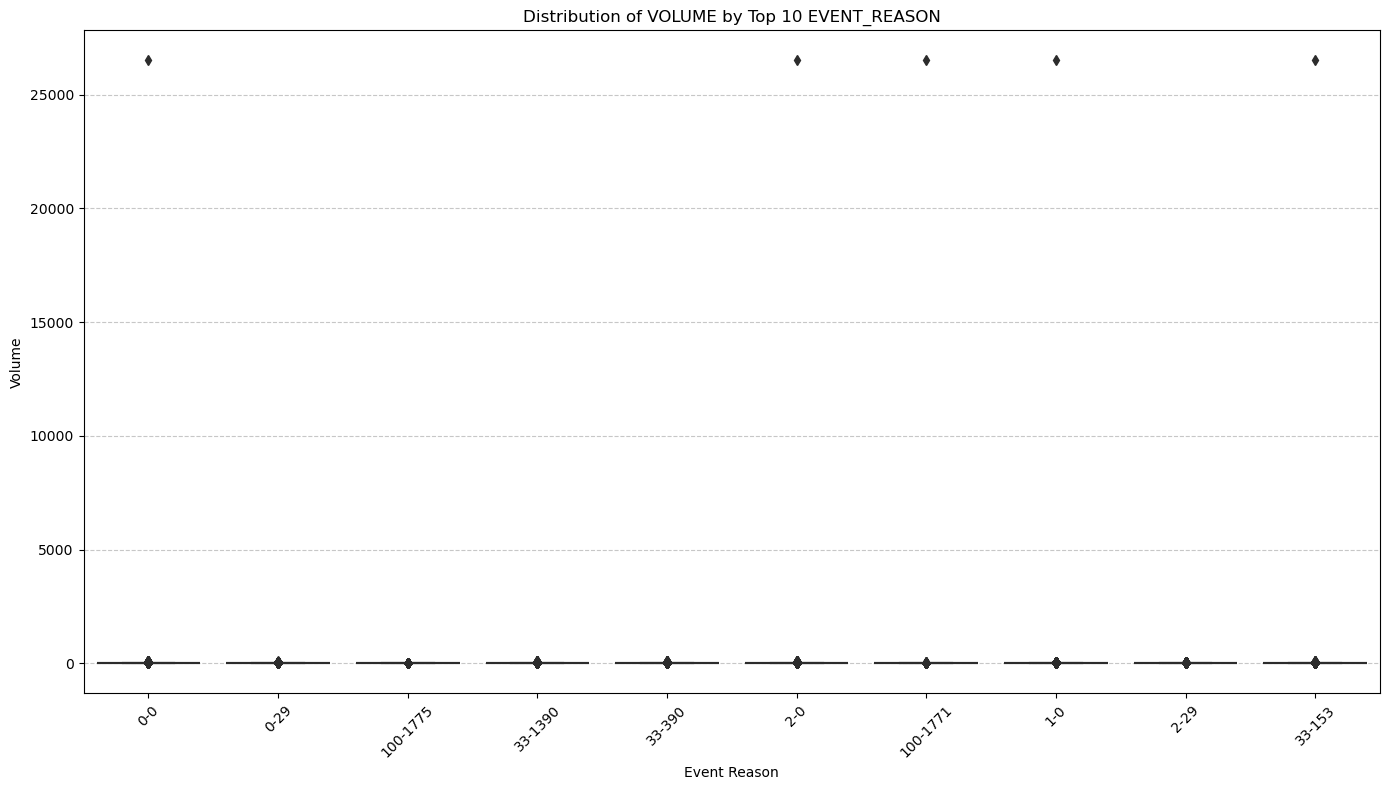

In [324]:
# Calculate the frequency distribution of EVENT_REASON
event_reason_counts = df_unique['EVENT_REASON'].value_counts()

# Get the top 10 most frequent EVENT_REASON values
top_10_event_reasons = event_reason_counts.nlargest(10).index

# Filter the DataFrame to include only rows with the top 10 EVENT_REASON values
df_top_10_event_reasons = df_unique[df_unique['EVENT_REASON'].isin(top_10_event_reasons)]

# Ensure 'EVENT_REASON' and 'VOLUME' are of the correct type
df_top_10_event_reasons['EVENT_REASON'] = df_top_10_event_reasons['EVENT_REASON'].astype(str)  # Convert to string if not already

# Create a boxplot to visualize the distribution of VOLUME for each of the top 10 EVENT_REASON values
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_top_10_event_reasons, x='EVENT_REASON', y='VOLUME', palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Volume')
plt.title('Distribution of VOLUME by Top 10 EVENT_REASON')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### Missing volumes per event reason

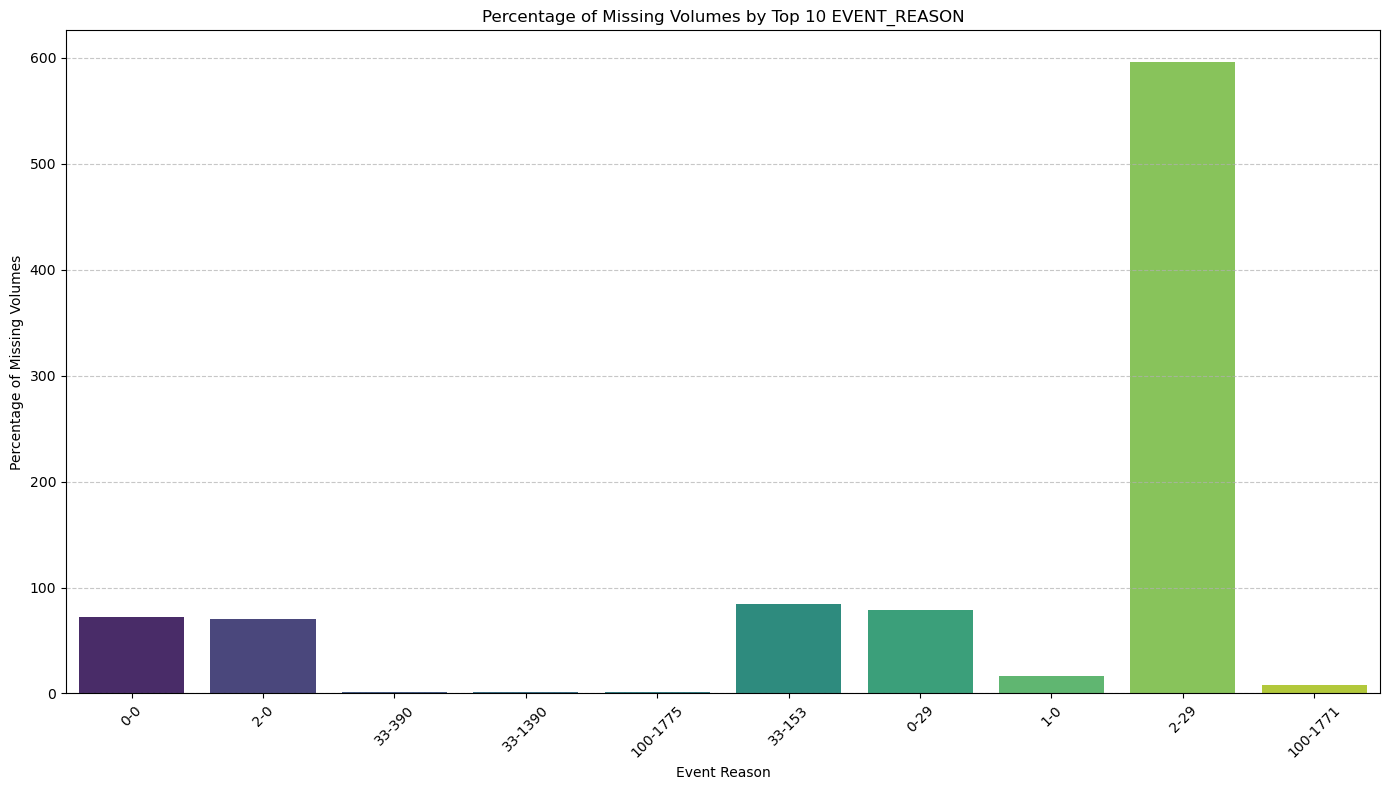

In [325]:
# Filter out rows where VOLUME is missing
df_non_missing_volume = df_unique[df_unique['VOLUME'].notna()]
# Calculate the total number of entries for each EVENT_REASON
total_counts_per_event = df_non_missing_volume['EVENT_REASON'].value_counts()

# Calculate the count of missing volumes for each EVENT_REASON
missing_volume_counts = df_unique[df_unique['VOLUME'].isna() & df_unique['EVENT_REASON'].isin(top_10_event_reasons)]
missing_volume_counts = missing_volume_counts['EVENT_REASON'].value_counts()

# Calculate the percentage of missing volumes for each EVENT_REASON
percentage_missing_volumes = (missing_volume_counts / total_counts_per_event) * 100
# Filter to include only the top 10 EVENT_REASON values
percentage_missing_volumes = percentage_missing_volumes.loc[top_10_event_reasons]

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x=percentage_missing_volumes.index, y=percentage_missing_volumes.values, palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Percentage of Missing Volumes')
plt.title('Percentage of Missing Volumes by Top 10 EVENT_REASON')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Event code 2-29 which is Inbound sorted as Business-Small Parcel has the most missing volumes for all depots.
It makes sense because small parcels are hard to 'calculate' volumes for.

Percentage of SMALL parcels with missing volumes: 55.60%


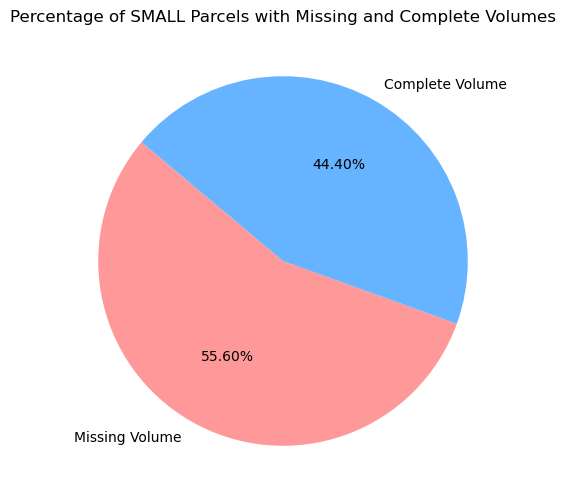

In [346]:
# Step 2: Ensure SCAN_DATETIME is in datetime format
df_unique['SCAN_DATETIME'] = pd.to_datetime(df_unique['SCAN_DATETIME'])
sorted_df = df_unique.sort_values(by=['UNITNO', 'SCAN_DATETIME'], ascending=[True, True])

# Step 4: Drop duplicates, keeping the first occurrence of each UNITNO
first_occurrence_df = sorted_df.drop_duplicates(subset='UNITNO', keep='first')

small_parcels_df = first_occurrence_df[first_occurrence_df['SMALL']]

# Step 2: Count total and missing volume rows
total_small_parcels = len(small_parcels_df)
missing_volume_count = small_parcels_df['VOLUME'].isna().sum()

# Calculate the percentage of missing volumes
missing_volume_percentage = (missing_volume_count / total_small_parcels) * 100
complete_volume_percentage = 100 - missing_volume_percentage

# Output the percentage of missing volumes
print(f"Percentage of SMALL parcels with missing volumes: {missing_volume_percentage:.2f}%")

# Step 3: Visualization
# Define labels and values
labels = ['Missing Volume', 'Complete Volume']
values = [missing_volume_percentage, complete_volume_percentage]

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%.2f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title('Percentage of SMALL Parcels with Missing Volumes')
plt.show()

This isn't a drastic difference.

## Missing volumes per event reason FOR DEPOT 120

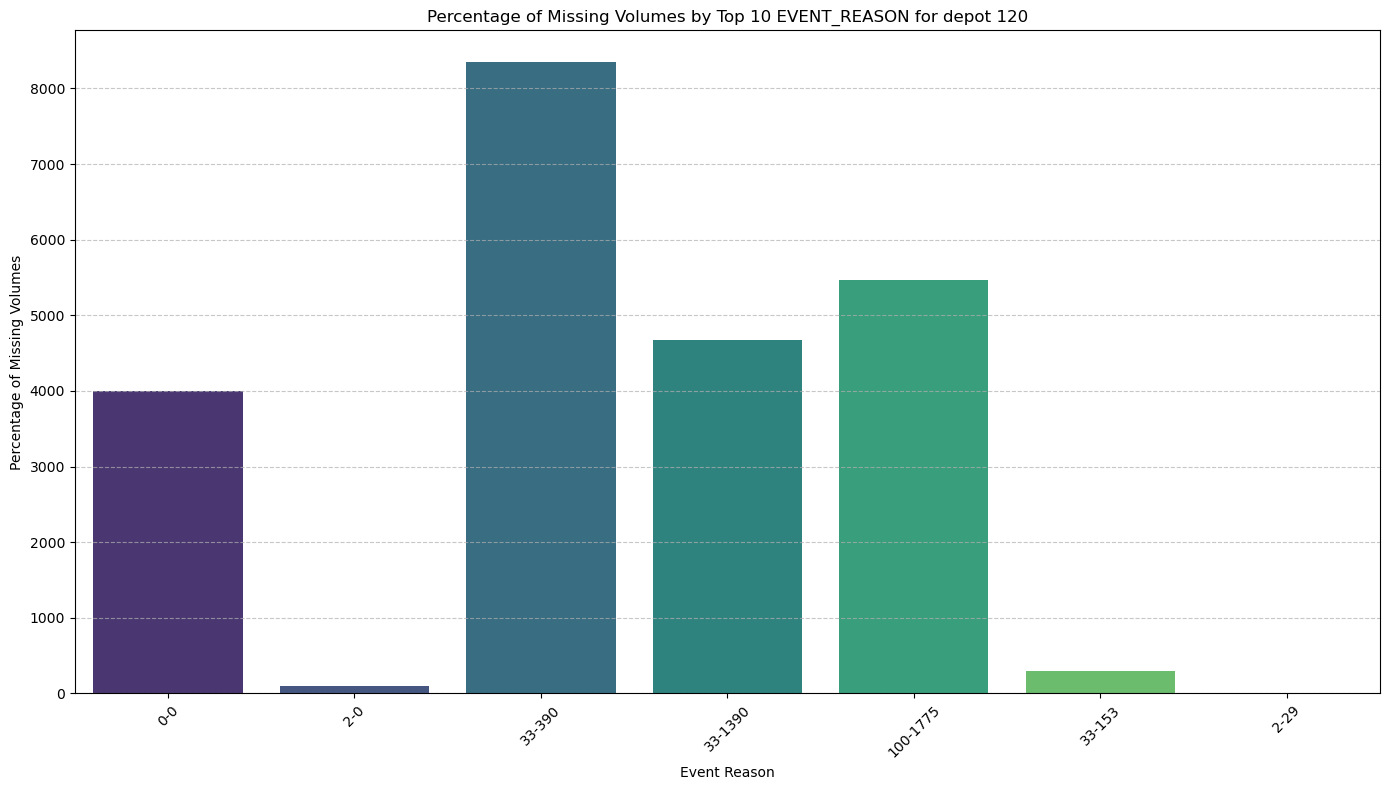

In [347]:
# Filter out rows where VOLUME is missing
df_non_missing_volume = df_120[df_120['VOLUME'].notna()]

# Sort and find the first occurrence per UNITNO
sorted_df = df_non_missing_volume.sort_values(by=['UNITNO', 'SCAN_DATETIME'], ascending=[True, True])
first_occurrence_df = sorted_df.drop_duplicates(subset='UNITNO', keep='first')

# Also find the first occurrence including rows with missing VOLUME
sorted_df_120 = df_120.sort_values(by=['UNITNO', 'SCAN_DATETIME'], ascending=[True, True])
first_occurrence_df_120 = sorted_df_120.drop_duplicates(subset='UNITNO', keep='first')

# Calculate the total number of entries for each EVENT_REASON
total_counts_per_event = first_occurrence_df['EVENT_REASON'].value_counts()

# Calculate the count of missing volumes for each EVENT_REASON
missing_volume_counts = first_occurrence_df_120[first_occurrence_df_120['VOLUME'].isna()]['EVENT_REASON'].value_counts()

# Calculate the percentage of missing volumes for each EVENT_REASON
percentage_missing_volumes = (missing_volume_counts / total_counts_per_event) * 100

# Filter to include only the top 10 EVENT_REASON values that are present in the index
valid_event_reasons = [reason for reason in top_10_event_reasons if reason in percentage_missing_volumes.index]
percentage_missing_volumes = percentage_missing_volumes.loc[valid_event_reasons]

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x=percentage_missing_volumes.index, y=percentage_missing_volumes.values, palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Percentage of Missing Volumes')
plt.title('Percentage of Missing Volumes by Top 10 EVENT_REASON for depot 120')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

For depot 120, it is event reason 33-390 that has the most volumes missing: Change completed for Volume weight --> did they have a volume before and then this event happened and they lost it?


In [19]:
# Step 2: Sort by UNITNO and SCAN_DATETIME to identify the first occurrence
df_120_sorted = df_120.sort_values(by=['UNITNO', 'SCAN_DATETIME'], ascending=[True, True])

# Step 3: Identify the first occurrence for each UNITNO
first_occurrences = df_120_sorted.drop_duplicates(subset='UNITNO', keep='first')

# Step 4: Check if the first occurrence EVENT_REASON is "33-390"
first_occurrence_is_33_390 = first_occurrences['EVENT_REASON'] == '33-390'

# Calculate the percentage of first occurrences that are "33-390"
percentage_33_390 = first_occurrence_is_33_390.mean() * 100
percentage_not_33_390 = (1 - first_occurrence_is_33_390.mean()) * 100

# Output the percentages
print(f"Percentage of first occurrences with EVENT_REASON '33-390': {percentage_33_390:.2f}%")
print(f"Percentage of first occurrences without EVENT_REASON '33-390': {percentage_not_33_390:.2f}%")

Percentage of first occurrences with EVENT_REASON '33-390': 0.17%
Percentage of first occurrences without EVENT_REASON '33-390': 99.83%


Therefore 33-390 usually comes AFTER another event code.

In [63]:
# Ensure SCAN_DATETIME is a datetime type
df_120['SCAN_DATETIME'] = pd.to_datetime(df_120['SCAN_DATETIME'])

# Step 1: Filter rows with EVENT_REASON "33-390"
df_33_390 = df_120[df_120['EVENT_REASON'].str.contains('33-390')]

# Step 2: Merge the DataFrame with itself to find earlier records for the same UNITNO
# Using suffixes to differentiate the columns from the left and right DataFrame
merged_df = df_120.merge(df_33_390, on='UNITNO', suffixes=('', '_33_390'))

# Remove rows where ON_TIME_33_390 is missing
merged_df_cleaned = merged_df.dropna(subset=['ON_TIME_33_390'])

# Step 3: Filter rows where SCAN_DATETIME is earlier and EVENT_REASON is different from "33-390"
results = merged_df_cleaned[
    (merged_df['SCAN_DATETIME'] < merged_df['SCAN_DATETIME_33_390']) &
    (~merged_df['EVENT_REASON'].str.contains('33-390')) &
    (merged_df['EVENT_REASON_33_390'] == '33-390')
]
# Select relevant columns to display
results = results[df_120.columns]

# Step 4: Filter rows where SCAN_DATETIME is earlier, EVENT_REASON is different from "33-390",
# and EVENT_REASON_33_390 is exactly "33-390"
results33390 = merged_df_cleaned[
    (merged_df['SCAN_DATETIME'] < merged_df['SCAN_DATETIME_33_390']) &
    (~merged_df['EVENT_REASON'].str.contains('33-390')) &
    (merged_df['EVENT_REASON_33_390'] == '33-390')
]

# Select relevant columns for the 33-390 event
results33390 = results33390[[col for col in merged_df.columns if col.endswith('_33_390')]]

# Remove the '_33_390' suffix from column names
results33390.columns = [col.replace('_33_390', '') for col in results33390.columns]


/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_76032/2533117414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_120['SCAN_DATETIME'] = pd.to_datetime(df_120['SCAN_DATETIME'])


In [65]:
print(merged_df_cleaned.head(5))

        UNITNO           SCAN_DATETIME  EVENT_CODE  EVENT_R  WEIGHT  VOLUME  \
0  10140009485 2024-07-16 15:46:12.881           0        0     1.2     NaN   
1  10140009485 2024-07-16 15:46:12.882           0       29     1.2     NaN   
2  10140009485 2024-07-17 13:34:15.686           2        0     1.2     NaN   
3  10140009485 2024-07-17 13:35:35.000         100     1771     1.2     NaN   
4  10140009485 2024-07-17 13:36:47.000          33      390     1.2     NaN   

   STACKABLE  SMALL  HAZARDOUS  BELT  ... PREVIOUS_SCAN_DATETIME_33_390  \
0      False   True      False  True  ...           2024-07-17 13:35:35   
1      False   True      False  True  ...           2024-07-17 13:35:35   
2      False   True      False  True  ...           2024-07-17 13:35:35   
3      False   True      False  True  ...           2024-07-17 13:35:35   
4      False   True      False  True  ...           2024-07-17 13:35:35   

  EVENT_REASON_33_390 SCAN_WEEK_OF_YEAR_33_390 SCAN_DAY_OF_WEEK_33_390  \


In [67]:
# Calculate the number of rows where 'ON_TIME' is True
on_time_count = results['ON_TIME'].sum()

# Calculate the total number of rows in the DataFrame
total_count = len(results)

# Calculate the percentage of rows where 'ON_TIME' is True
on_time_percentage = (on_time_count / total_count) * 100

print(f"Percentage of rows where ON_TIME is True: {on_time_percentage:.2f}%")

Percentage of rows where ON_TIME is True: 70.00%


In [69]:
# Calculate the number of rows where 'ON_TIME' is True
on_time_count = results33390['ON_TIME'].sum()

# Calculate the total number of rows in the DataFrame
total_count = len(results33390)

# Calculate the percentage of rows where 'ON_TIME' is True
on_time_percentage = (on_time_count / total_count) * 100

print(f"Percentage of rows where ON_TIME is True: {on_time_percentage:.2f}%")

Percentage of rows where ON_TIME is True: 68.08%


In [75]:
# Filter rows where ON_TIME and ON_TIME_33_390 are different
filtered_df = merged_df_cleaned[merged_df_cleaned['ON_TIME'] != merged_df_cleaned['ON_TIME_33_390']]

# Select only necessary columns
filtered_df_selected = filtered_df[['UNITNO', 'ON_TIME', 'ON_TIME_33_390']]

# Print the selected columns
print(filtered_df_selected)

             UNITNO  ON_TIME  ON_TIME_33_390
26      10140014057    False            True
27      10140014057    False            True
28      10140014057    False            True
29      10140014057    False            True
36      10140014208    False            True
...             ...      ...             ...
247992  89502926908     True           False
247998  89502926966     True           False
247999  89502926966     True           False
248005  89502926978     True           False
248006  89502926978     True           False

[6554 rows x 3 columns]


In [134]:
# Group by UNITNO and find groups with more than one unique SCAN_DATETIME
different_scan_datetime = df_unique.groupby('UNITNO').filter(
    lambda x: x['SCAN_DATETIME'].nunique() > 1
)

# Print the result
print(different_scan_datetime)

               UNITNO           SCAN_DATETIME  EVENT_CODE  EVENT_R  WEIGHT  \
33379142  10000002958 2024-07-18 16:19:56.000           0        0    1.48   
34103840  10000002958 2024-07-18 16:19:56.730           0       29    1.48   
6214575   10000002958 2024-07-18 23:00:29.000         100     1775    1.48   
58472283  10000002958 2024-07-18 23:00:29.000          33     1390    1.48   
79391695  10000002958 2024-07-18 23:00:29.000          33      390    1.48   
...               ...                     ...         ...      ...     ...   
87456322  99988088697 2024-07-18 14:22:13.294          27       54   11.90   
87456323  99988088697 2024-07-18 14:22:18.510          27       67   11.90   
80480491  99988088697 2024-07-18 14:22:23.790          27       68   11.90   
52592213  99988088697 2024-07-18 14:22:34.283          27       58   11.90   
80480490  99988088697 2024-07-18 20:12:32.875           1        0   11.90   

          VOLUME  STACKABLE  SMALL  HAZARDOUS  BELT  ...  \
333

In [112]:
# Sort the DataFrame by UNITNO and SCAN_DATETIME
df_unique_sorted = df_unique.sort_values(by=['UNITNO', 'SCAN_DATETIME'])

# Shift the UNITNO and SCAN_DATETIME columns by one to compare with the previous row
df_unique_sorted['PREV_UNITNO'] = df_unique_sorted['UNITNO'].shift(1)
df_unique_sorted['PREV_SCAN_DATETIME'] = df_unique_sorted['SCAN_DATETIME'].shift(1)

# Identify rows where UNITNO is the same as the previous row but SCAN_DATETIME is different
different_scan_datetime = df_unique_sorted[
    (df_unique_sorted['UNITNO'] == df_unique_sorted['PREV_UNITNO']) &
    (df_unique_sorted['SCAN_DATETIME'] != df_unique_sorted['PREV_SCAN_DATETIME'])
]

# Drop the helper columns used for comparison
different_scan_datetime = different_scan_datetime.drop(columns=['PREV_UNITNO', 'PREV_SCAN_DATETIME'])

# Print the results
print(different_scan_datetime)



KeyboardInterrupt



# Check if all unitno have the same scandatetime

In [81]:
# Filter rows where ON_TIME and ON_TIME_33_390 are different
# and VOLUME is not NaN
filtered_df = merged_df_cleaned[
    (merged_df_cleaned['VOLUME'] != merged_df_cleaned['VOLUME_33_390']) &
    (merged_df_cleaned['VOLUME'].notna())
]

# Select only necessary columns
filtered_df_selected = filtered_df[['UNITNO', 'VOLUME', 'VOLUME_33_390']]

# Print the selected columns
print(filtered_df_selected)

Empty DataFrame
Columns: [UNITNO, VOLUME, VOLUME_33_390]
Index: []


## They did not LOSE the volume after event 33_390.

# Top events with missing volumes

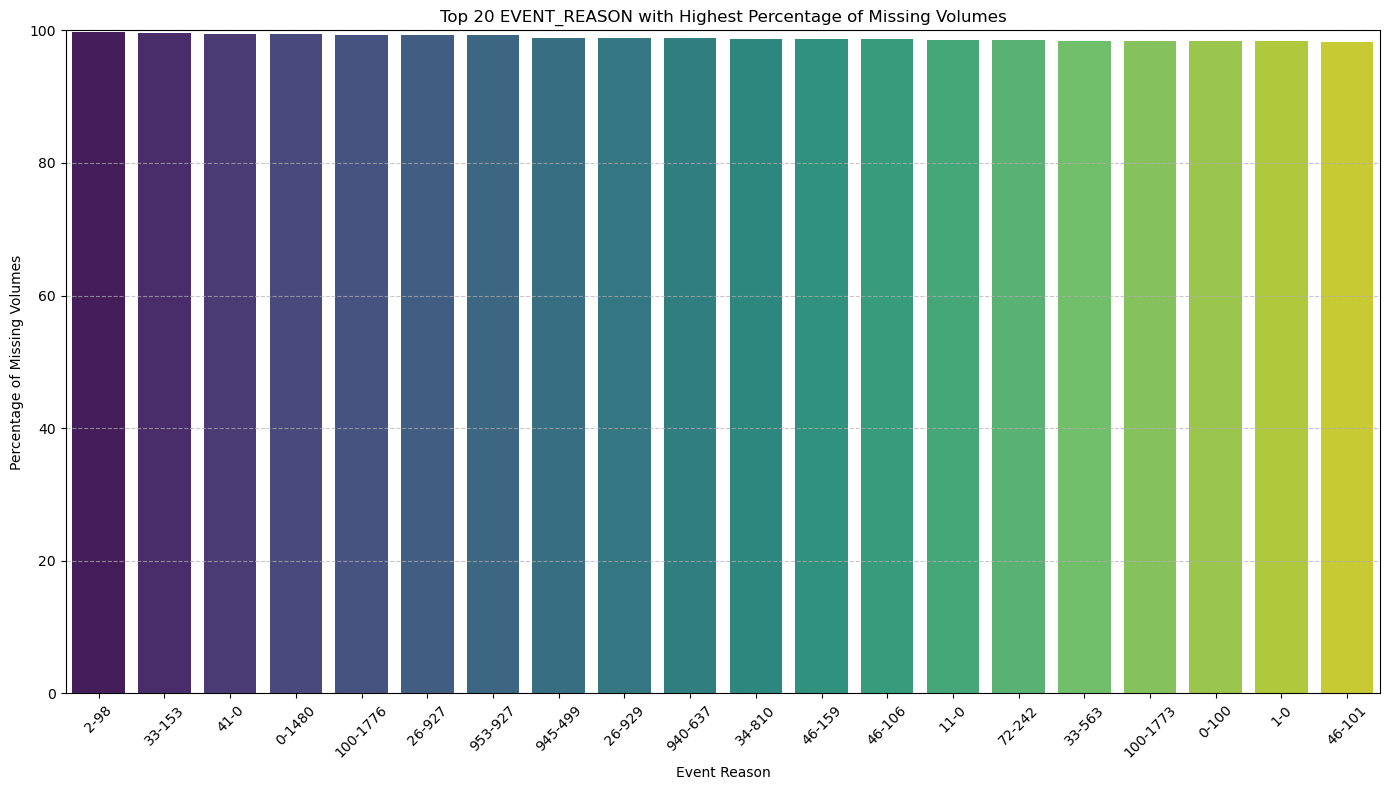

In [330]:
# Filter out rows where VOLUME is missing
df_non_missing_volume = df_120[df_120['VOLUME'].notna()]
total_counts_per_event = df_non_missing_volume['EVENT_REASON'].value_counts()

# Calculate missing volume counts
missing_volume_counts = df_120[df_120['VOLUME'].isna()]
missing_volume_counts = missing_volume_counts['EVENT_REASON'].value_counts()

# Calculate the percentage of missing volumes for each EVENT_REASON
missing_volume_percentage = (missing_volume_counts / (total_counts_per_event + missing_volume_counts) ) * 100

# Sort and get the top 10 EVENT_REASON values with the highest percentage of missing volumes
top_20_missing_percentage = missing_volume_percentage.nlargest(20)

# Create a bar plot for the top 10 EVENT_REASON with highest missing volume percentages
plt.figure(figsize=(14, 8))
sns.barplot(x=top_20_missing_percentage.index, y=top_20_missing_percentage.values, palette='viridis')

# Customize the plot
plt.xlabel('Event Reason')
plt.ylabel('Percentage of Missing Volumes')
plt.title('Top 20 EVENT_REASON with Highest Percentage of Missing Volumes')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Same results with absolute values and percentages.

In [348]:
print(top_20_missing_percentage)

EVENT_REASON
2-98        99.719364
33-153      99.537279
41-0        99.492386
0-1480      99.382716
100-1776    99.371069
26-927      99.324324
953-927     99.310345
945-499     98.863636
26-929      98.823529
940-637     98.809524
34-810      98.757764
46-159      98.648649
46-106      98.631124
11-0        98.484848
72-242      98.484848
33-563      98.443580
100-1773    98.407885
0-100       98.393574
1-0         98.342261
46-101      98.284286
Name: count, dtype: float64


In [ ]:
# Step 1: Filter data for DESTINATION_DEPOT_ID 120, where VOLUME is missing, and EVENT_REASON is one of the specified values
event_reasons_of_interest = [
    '2-98', '33-153', '41-0', '0-1480', '100-1776',
    '26-927', '953-927', '945-499', '26-929', '940-637',
    '34-810', '46-159', '46-106', '11-0', '72-242',
    '33-563', '100-1773', '0-100', '1-0', '46-101'
]

data_depot_120_missing_volume = df_novolume_120[
    (df_novolume_120['EVENT_REASON'].isin(event_reasons_of_interest))
]

# Ensure that 'SCAN_DATETIME' is a datetime type
data_depot_120_missing_volume['SCAN_DATETIME'] = pd.to_datetime(data_depot_120_missing_volume['SCAN_DATETIME'])

# Add columns for day of the week and hour of the day
data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.dayofweek
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
    5: 'Saturday', 6: 'Sunday'
})
data_depot_120_missing_volume['SCAN_HOUR'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.hour

# Step 2: Exclude Saturday and Sunday
data_depot_120_missing_volume = data_depot_120_missing_volume[
    ~data_depot_120_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])
]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ordered=True
))

# Step 3: Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_missing_volume = (on_time_counts_depot_120_missing_volume / total_counts_depot_120_missing_volume) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_missing_volume = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_missing_volume.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_missing_volume = heatmap_data_depot_120_missing_volume.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_missing_volume = heatmap_pivot_depot_120_missing_volume.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 and Missing Volume Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_missing_volume, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, Missing Volume, Top 20 Event codes with the most missing volumes])')

# Show the plot
plt.tight_layout()
plt.show()


For the 20 specific event codes with the most missing percentages of volumes, the trend of lower on_time deliveries between 9 and 10 seems to be relevant for all days besides Friday.

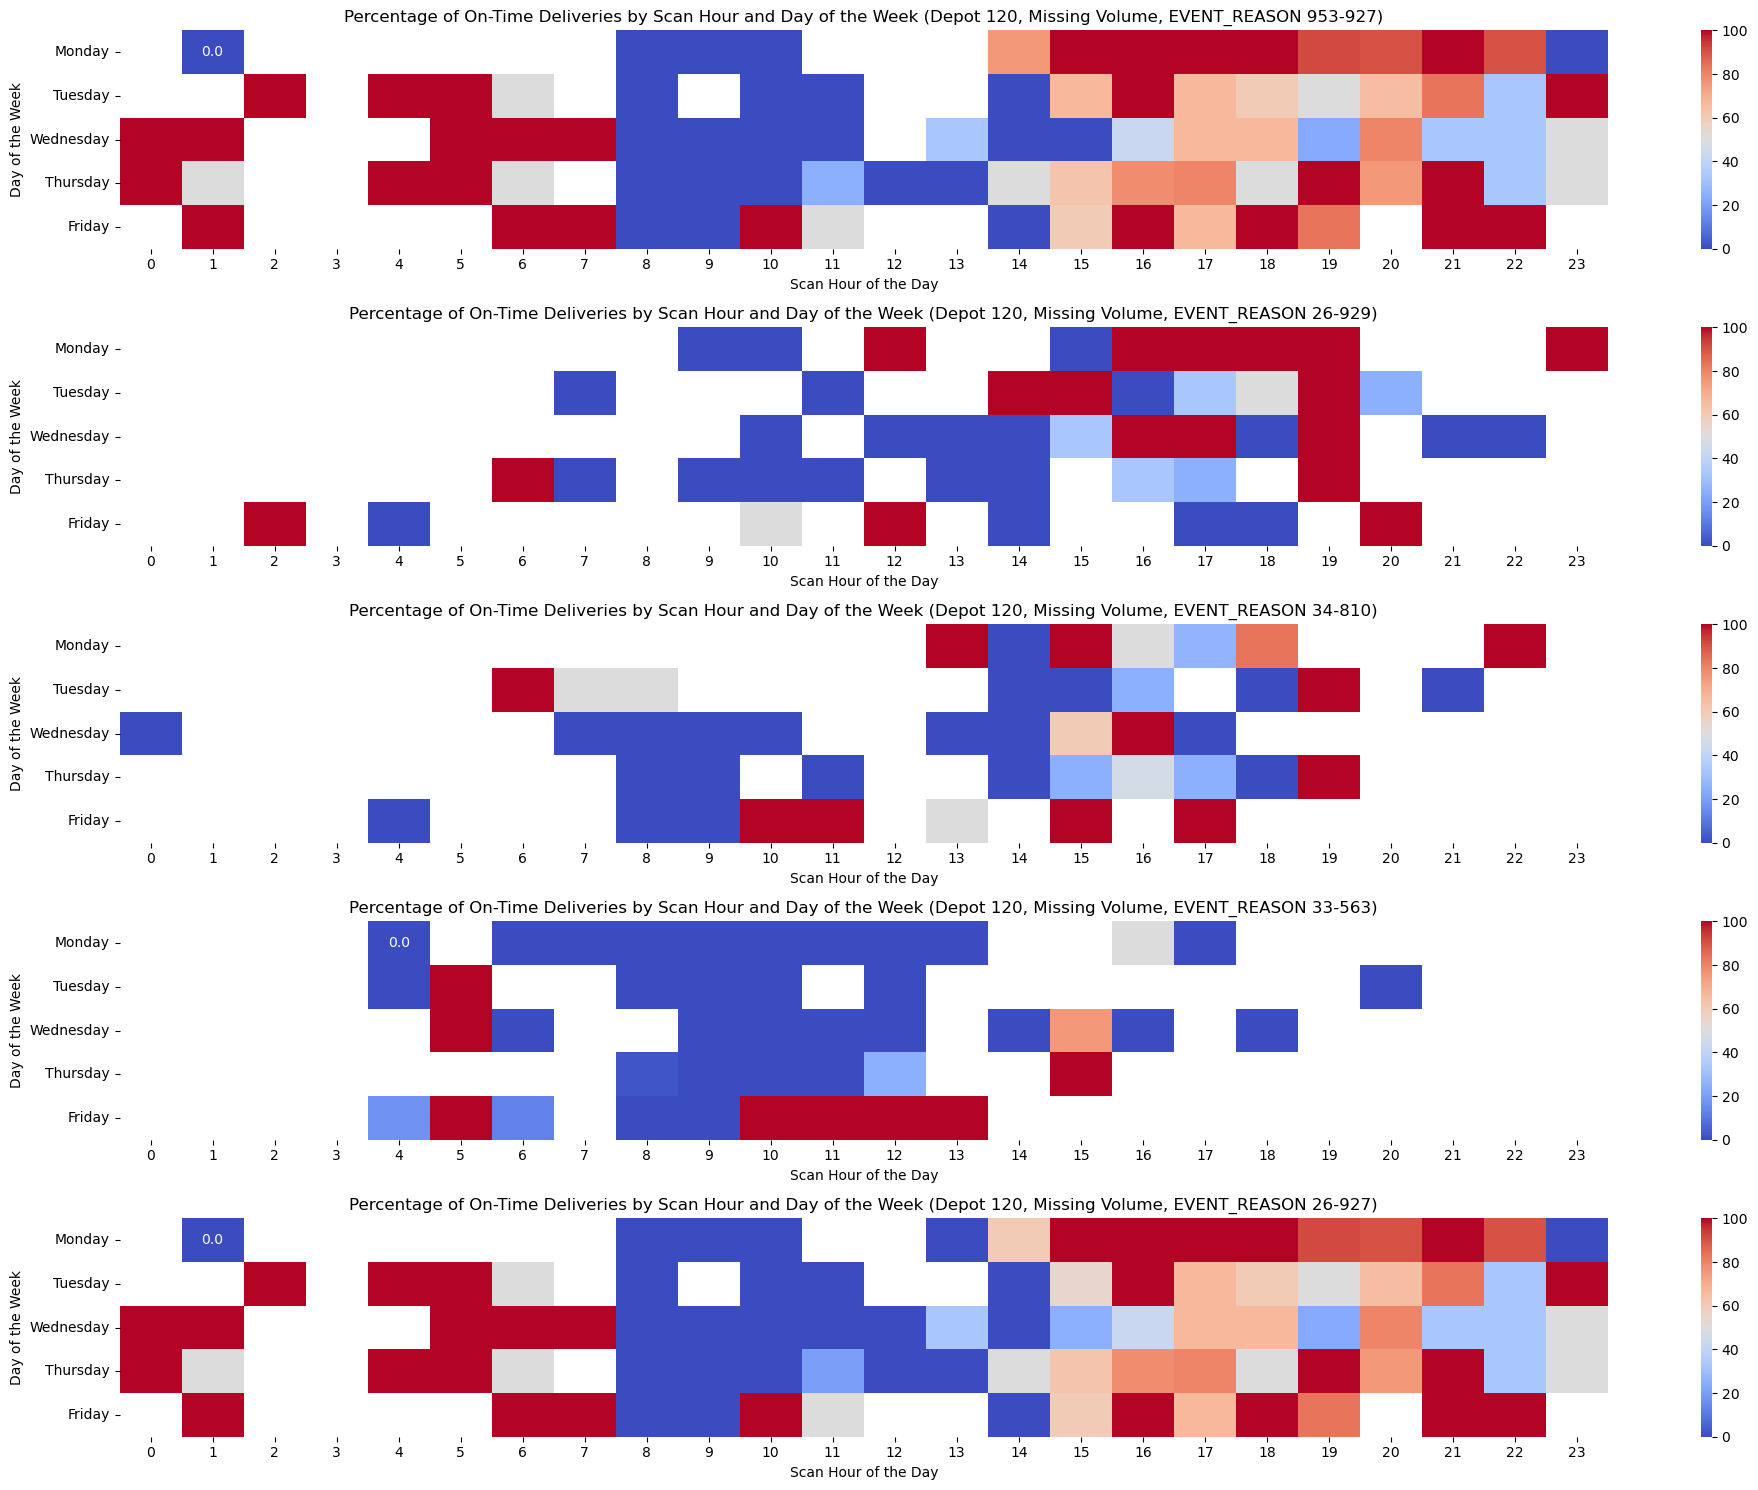

In [367]:
# List of EVENT_REASON values to analyze
event_reasons_of_interest = [
    '953-927', '26-929', '34-810', '33-563', '26-927'
]

# Filter data for specified EVENT_REASON values and where VOLUME is missing
data_depot_120_missing_volume = df_novolume_120[
    (df_novolume_120['EVENT_REASON'].isin(event_reasons_of_interest)) &
    (df_novolume_120['VOLUME'].isna())
]

# Ensure that 'SCAN_DATETIME' is a datetime type
data_depot_120_missing_volume['SCAN_DATETIME'] = pd.to_datetime(data_depot_120_missing_volume['SCAN_DATETIME'])

# Add columns for day of the week and hour of the day
data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.dayofweek
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
    5: 'Saturday', 6: 'Sunday'
})
data_depot_120_missing_volume['SCAN_HOUR'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.hour

# Exclude Saturday and Sunday
data_depot_120_missing_volume = data_depot_120_missing_volume[
    ~data_depot_120_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])
]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ordered=True
))

# Create a figure for plotting
plt.figure(figsize=(20, 15))

# Plot for each EVENT_REASON separately
for i, event_reason in enumerate(event_reasons_of_interest):
    # Filter data for the specific EVENT_REASON
    data_event_reason = data_depot_120_missing_volume[
        data_depot_120_missing_volume['EVENT_REASON'] == event_reason
    ]
    
    # Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
    on_time_counts_event_reason = data_event_reason.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
    total_counts_event_reason = data_event_reason.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
    percentage_on_time_event_reason = (on_time_counts_event_reason / total_counts_event_reason) * 100
    
    # Create a DataFrame for plotting
    heatmap_data_event_reason = pd.DataFrame({
        'SCAN_HOUR': percentage_on_time_event_reason.index.get_level_values('SCAN_HOUR'),
        'SCAN_DAY_NAME': percentage_on_time_event_reason.index.get_level_values('SCAN_DAY_NAME'),
        'Percentage_On_Time': percentage_on_time_event_reason.values
    })
    
    # Pivot the data for heatmap
    heatmap_pivot_event_reason = heatmap_data_event_reason.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')
    
    # Ensure correct ordering of columns and index
    heatmap_pivot_event_reason = heatmap_pivot_event_reason.reindex(
        columns=range(24),  # Assuming hours from 0 to 23
        index=pd.CategoricalIndex(
            ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
            categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
            ordered=True
        )
    )
    
    # Plotting for the current EVENT_REASON
    plt.subplot(len(event_reasons_of_interest), 1, i + 1)
    sns.heatmap(heatmap_pivot_event_reason, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)
    
    # Customize the plot
    plt.xlabel('Scan Hour of the Day')
    plt.ylabel('Day of the Week')
    plt.title(f'Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, Missing Volume, EVENT_REASON {event_reason})')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


We can see that the 9-10 hour low on_time delivery trend is relevant for 
- 953-927: 	FDS Information - change order	Delivery on a defined date
- 26-929: Shipment locked	Delivery at new address
- 34-810 (Print completed	Collection reciept)
- 33-563 (Change completed for	collection or delivery vehicle)
- 26-927 (Shipment locked	Delivery on a defined date)

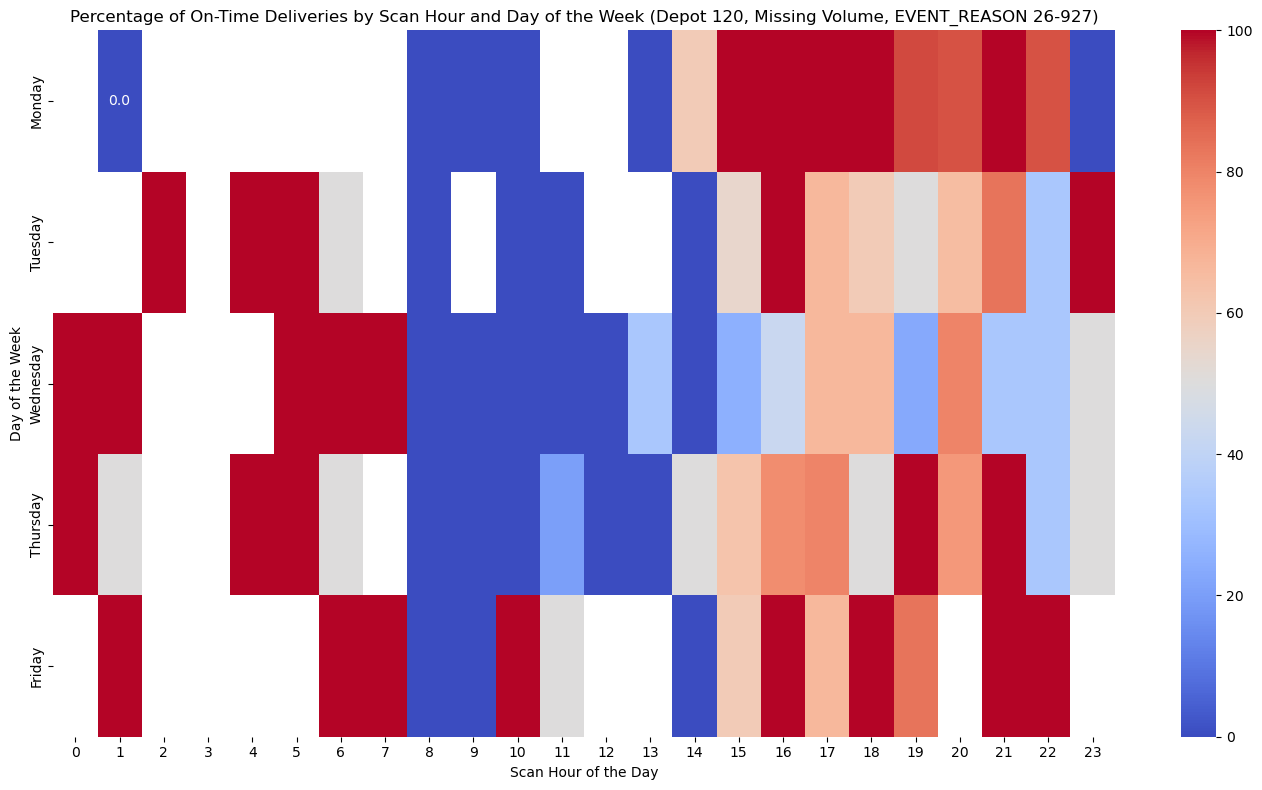

In [372]:
# Step 1: Filter data for DESTINATION_DEPOT_ID 120, where VOLUME is missing, and EVENT_REASON is 927
data_depot_120_missing_volume = df_novolume_120[
    (df_novolume_120['EVENT_REASON'] == '26-927')
]

# Ensure that 'SCAN_DATETIME' is a datetime type
data_depot_120_missing_volume['SCAN_DATETIME'] = pd.to_datetime(data_depot_120_missing_volume['SCAN_DATETIME'])

# Add columns for day of the week and hour of the day
data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.dayofweek
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
    5: 'Saturday', 6: 'Sunday'
})
data_depot_120_missing_volume['SCAN_HOUR'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.hour

# Step 2: Exclude Saturday and Sunday
data_depot_120_missing_volume = data_depot_120_missing_volume[
    ~data_depot_120_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])
]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ordered=True
))

# Step 3: Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_missing_volume = (on_time_counts_depot_120_missing_volume / total_counts_depot_120_missing_volume) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_missing_volume = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_missing_volume.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_missing_volume = heatmap_data_depot_120_missing_volume.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_missing_volume = heatmap_pivot_depot_120_missing_volume.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 and Missing Volume Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_missing_volume, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, Missing Volume, EVENT_REASON 26-927)')

# Show the plot
plt.tight_layout()
plt.show()

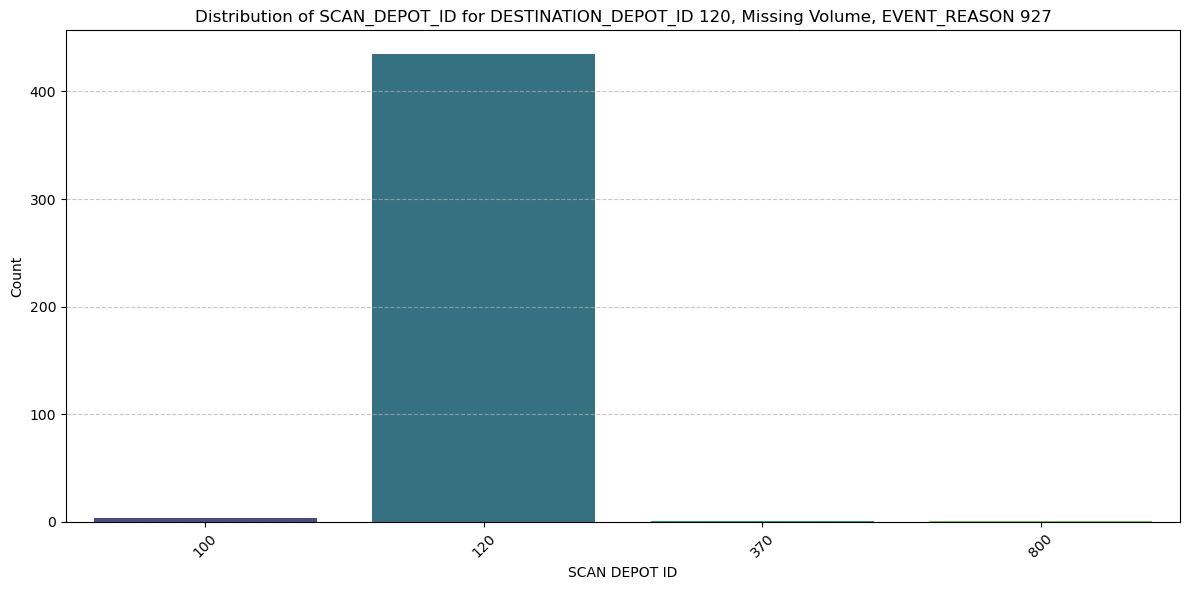

In [374]:
# Step 1: Filter data
data_filtered = df_novolume_120[
    (df_novolume_120['EVENT_REASON'] == '26-927')
]

# Step 2: Calculate the distribution of SCAN_DEPOT_ID
scan_depot_id_distribution = data_filtered['SCAN_DEPOT_ID'].value_counts()

# Step 3: Create a bar plot to visualize the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=scan_depot_id_distribution.index, y=scan_depot_id_distribution.values, palette='viridis')

# Customize the plot
plt.xlabel('SCAN DEPOT ID')
plt.ylabel('Count')
plt.title('Distribution of SCAN_DEPOT_ID for DESTINATION_DEPOT_ID 120, Missing Volume, EVENT_REASON 26-927')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

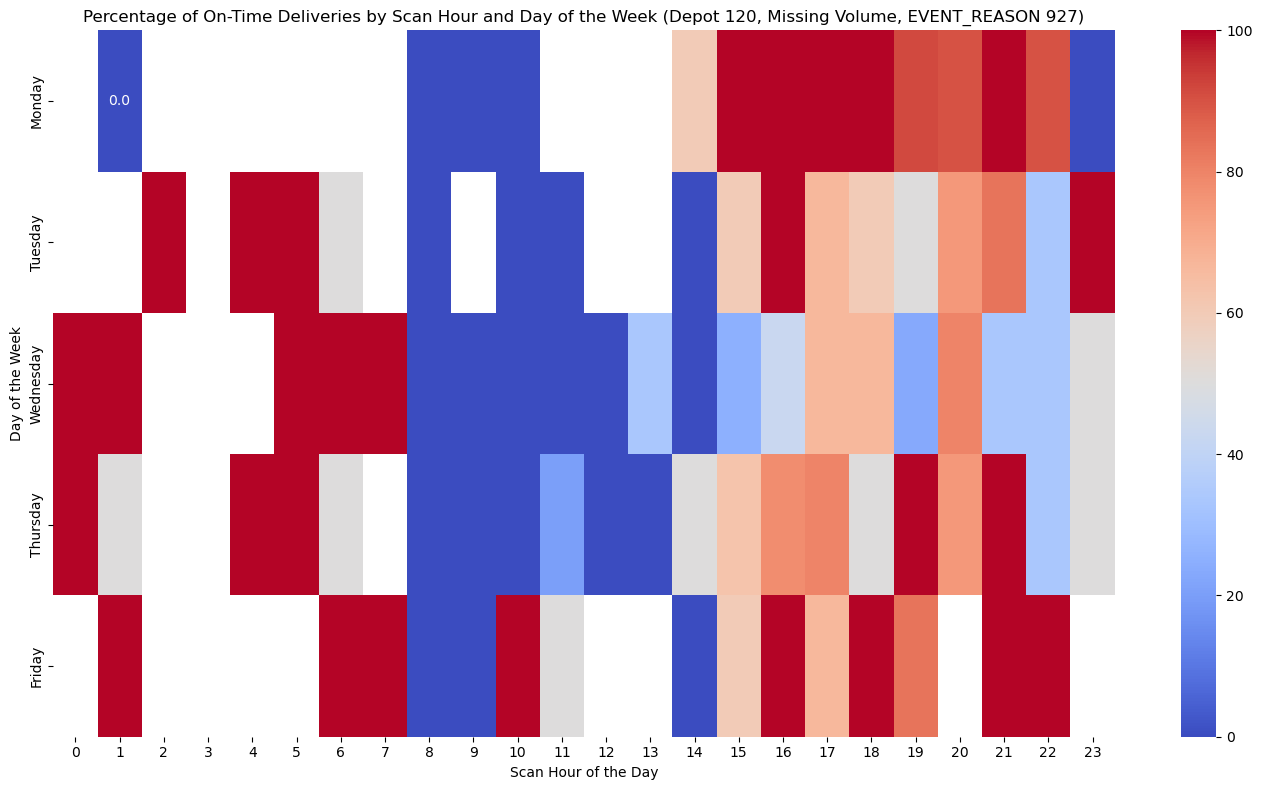

In [376]:
# Step 1: Filter data for DESTINATION_DEPOT_ID 120, SCAN_DEPOT_ID 120, where VOLUME is missing, and EVENT_REASON is 927
data_depot_120_missing_volume = df_novolume_120[
    (df_novolume_120['SCAN_DEPOT_ID'] == 120) &
    (df_novolume_120['EVENT_REASON'] == '26-927')
]

# Ensure that 'SCAN_DATETIME' is a datetime type
data_depot_120_missing_volume['SCAN_DATETIME'] = pd.to_datetime(data_depot_120_missing_volume['SCAN_DATETIME'])

# Add columns for day of the week and hour of the day
data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.dayofweek
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
    5: 'Saturday', 6: 'Sunday'
})
data_depot_120_missing_volume['SCAN_HOUR'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.hour

# Step 2: Exclude Saturday and Sunday
data_depot_120_missing_volume = data_depot_120_missing_volume[
    ~data_depot_120_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])
]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
    ordered=True
))

# Step 3: Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_missing_volume = (on_time_counts_depot_120_missing_volume / total_counts_depot_120_missing_volume) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_missing_volume = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_missing_volume.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_missing_volume = heatmap_data_depot_120_missing_volume.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_missing_volume = heatmap_pivot_depot_120_missing_volume.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 and Missing Volume Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_missing_volume, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, Missing Volume, EVENT_REASON 927)')

# Show the plot
plt.tight_layout()
plt.show()

### The trend of low on_time deliveries between 8 and 10 is relevant for parcels with depot_scan_id 120, destination_depot_id 120, missing volumes, and event_reason 26-927

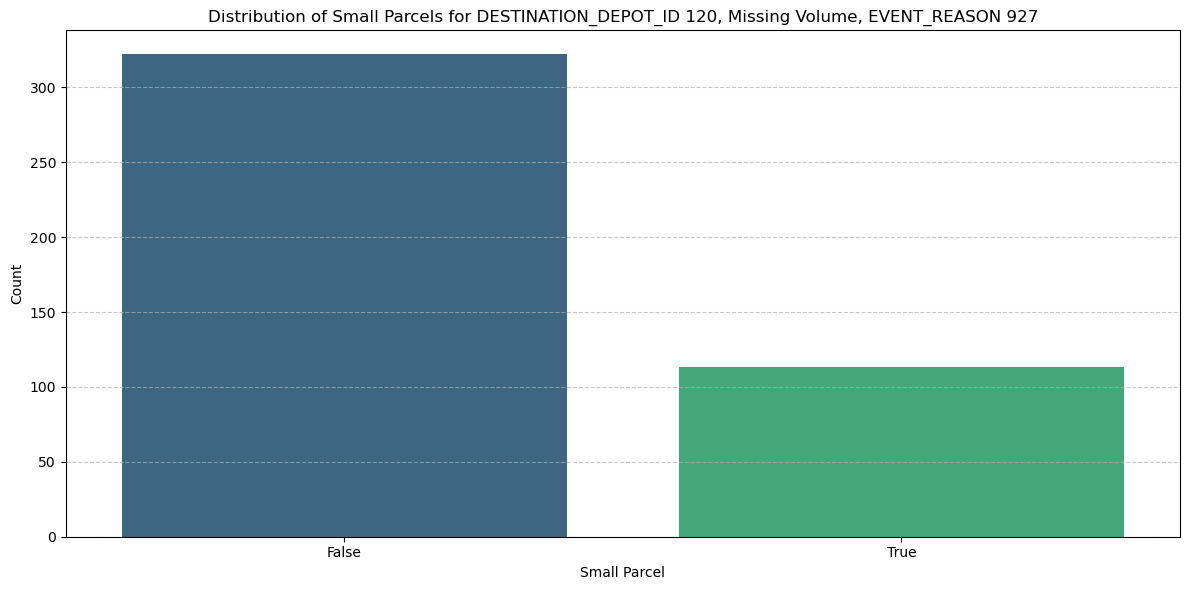

In [380]:
# Step 1: Filter data for DESTINATION_DEPOT_ID 120, SCAN_DEPOT_ID 120, where VOLUME is missing, and EVENT_REASON is 927
data_depot_120_missing_volume = df_novolume_120[
    (df_novolume_120['SCAN_DEPOT_ID'] == 120) &
    (df_novolume_120['EVENT_REASON'] == '26-927') 
]

# Plot distribution of SMALL parcels
plt.figure(figsize=(12, 6))
sns.countplot(x='SMALL', data=data_depot_120_missing_volume, palette='viridis')

# Customize the plot
plt.xlabel('Small Parcel')
plt.ylabel('Count')
plt.title('Distribution of Small Parcels for DESTINATION_DEPOT_ID 120, Missing Volume, EVENT_REASON 927')
plt.xticks([0, 1], ['False', 'True'])  # Set x-tick labels to 'False' and 'True'
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



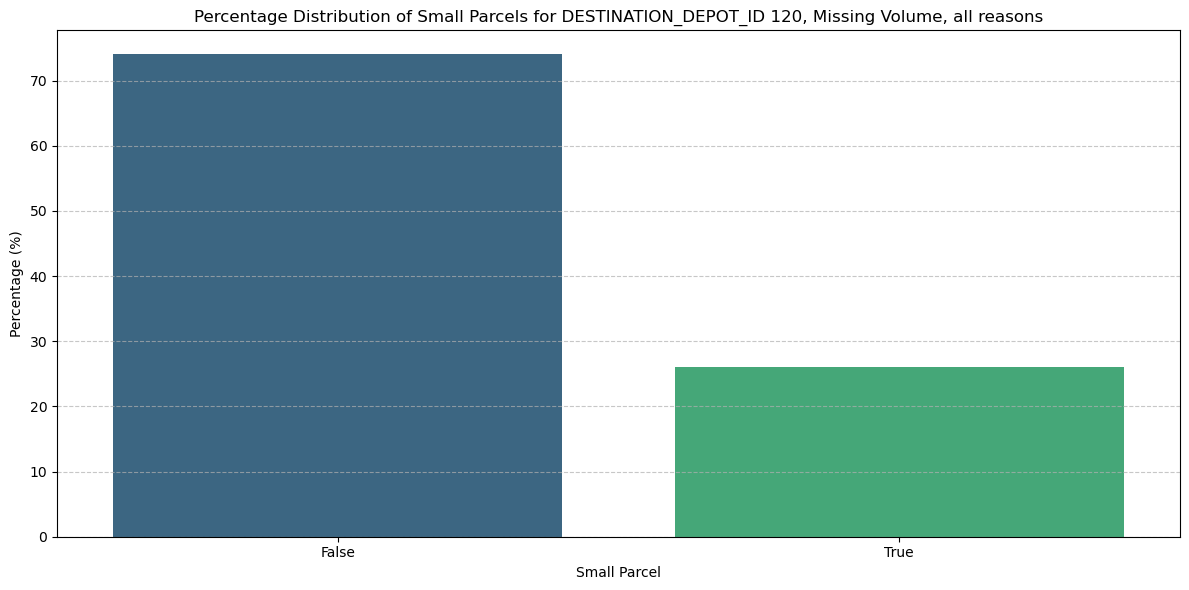

In [382]:
# Calculate the percentage distribution of SMALL parcels
small_distribution = data_depot_120_missing_volume['SMALL'].value_counts(normalize=True) * 100

# Plot distribution of SMALL parcels as percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=small_distribution.index, y=small_distribution.values, palette='viridis')

# Customize the plot
plt.xlabel('Small Parcel')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution of Small Parcels for DESTINATION_DEPOT_ID 120, Missing Volume, all reasons')
plt.xticks([0, 1], ['False', 'True'])  # Set x-tick labels to 'False' and 'True'
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Less than 30% of those parcels are small

In [384]:
# Step 1: Filter data for small parcels
all_small_parcels = df_novolume_120[df_novolume_120['SMALL'] == True]

# Step 2: Filter data for the specific group within small parcels
specific_group_small_parcels = all_small_parcels[
    (all_small_parcels['SCAN_DEPOT_ID'] == 120) &
    (all_small_parcels['EVENT_REASON'] == '26-927')
]

# Step 3: Calculate the percentage
total_small_parcels = len(all_small_parcels)
specific_group_count = len(specific_group_small_parcels)
percentage_specific_group = (specific_group_count / total_small_parcels) * 100

print(f"Percentage of all small parcels that are in the specific group: {percentage_specific_group:.2f}%")


Percentage of all small parcels that are in the specific group: 0.07%


In [386]:
# Step 1: Filter data for the specific group
specific_group_parcels = df_novolume_120[
    (df_novolume_120['SCAN_DEPOT_ID'] == 120) &
    (df_novolume_120['EVENT_REASON'] == '26-927')
]

# Step 2: Get the total number of parcels
total_parcels = len(df_novolume_120)

# Step 3: Get the number of parcels in the specific group
specific_group_count = len(specific_group_parcels)

# Step 4: Calculate the percentage
percentage_specific_group = (specific_group_count / total_parcels) * 100

print(f"Percentage of all parcels that are in the specific group: {percentage_specific_group:.2f}%")

Percentage of all parcels that are in the specific group: 0.09%


## Small does not seem significant

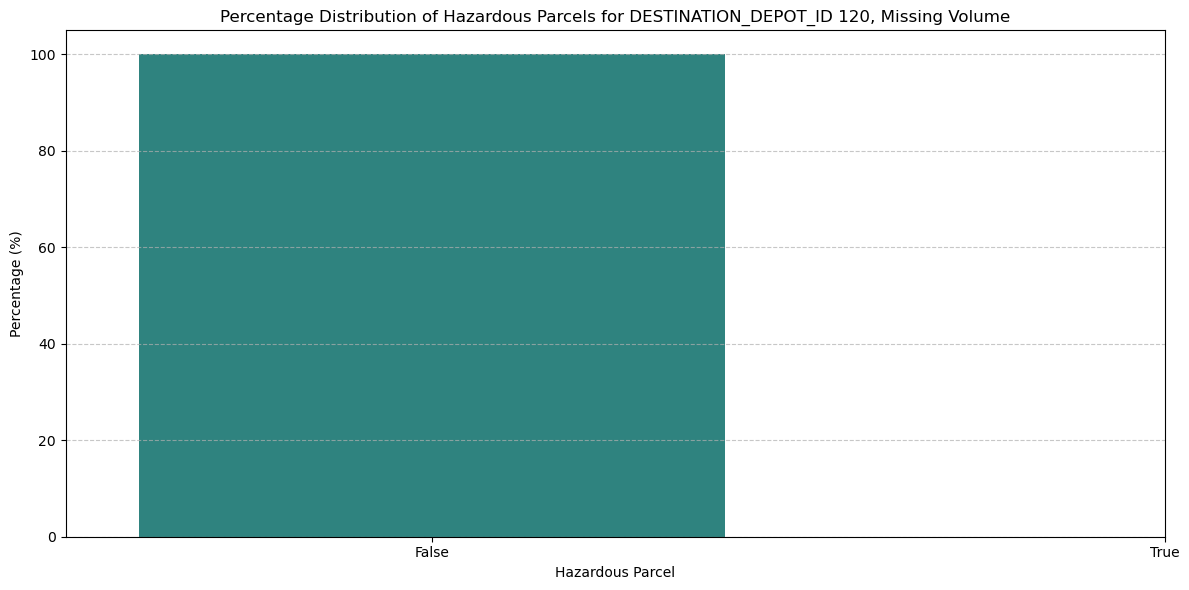

In [389]:
# Calculate the percentage distribution of SMALL parcels
hazardous_distribution = data_depot_120_missing_volume['HAZARDOUS'].value_counts(normalize=True) * 100

# Plot distribution of SMALL parcels as percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=hazardous_distribution.index, y=hazardous_distribution.values, palette='viridis')

# Customize the plot
plt.xlabel('Hazardous Parcel')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution of Hazardous Parcels for DESTINATION_DEPOT_ID 120, Missing Volume')
plt.xticks([0, 1], ['False', 'True']) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


And they are all not hazardous.

# Weight distribution of our specific group

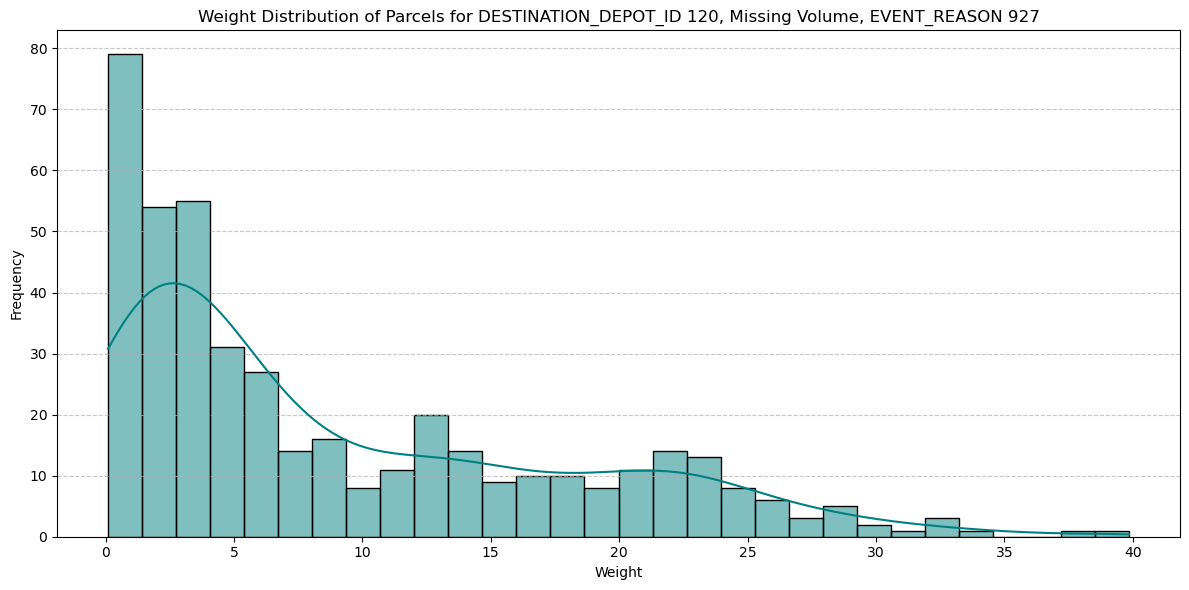

In [391]:
# Step 1: Filter data for the specific group
specific_group_parcels = df_novolume_120[
    (df_novolume_120['SCAN_DEPOT_ID'] == 120) &
    (df_novolume_120['EVENT_REASON'] == '26-927')
]

# Step 2: Plot weight distribution
plt.figure(figsize=(12, 6))

# Plotting histogram
sns.histplot(specific_group_parcels['WEIGHT'].dropna(), kde=True, bins=30, color='teal')

# Customize the plot
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution of Parcels for DESTINATION_DEPOT_ID 120, Missing Volume, EVENT_REASON 927')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

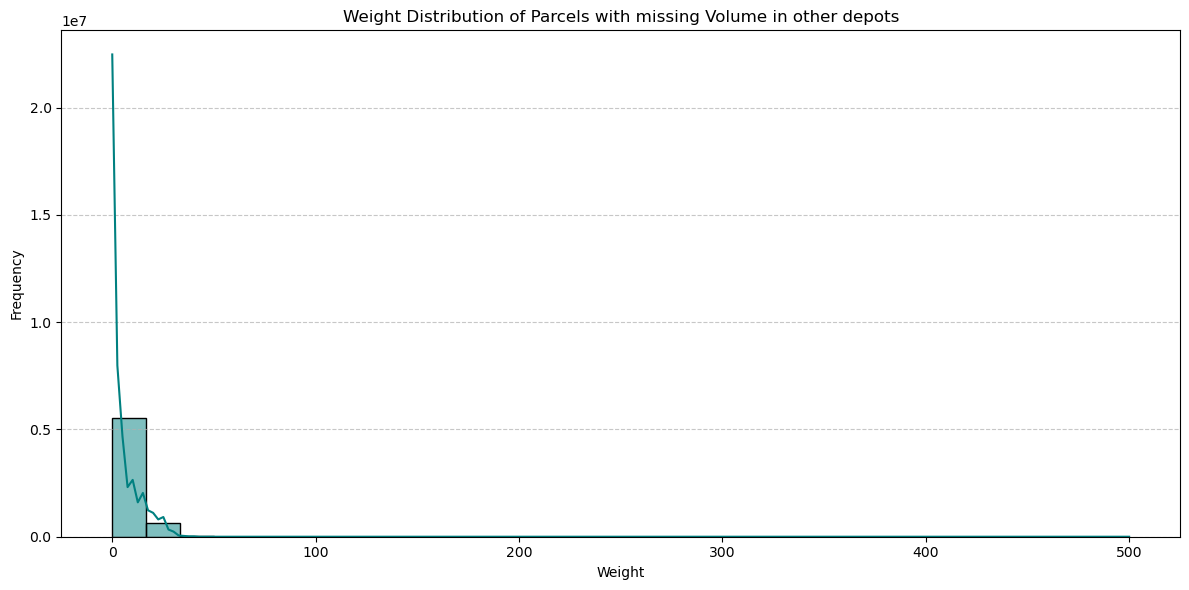

In [225]:

# Plot weight distribution
plt.figure(figsize=(12, 6))

# Plotting histogram
sns.histplot(df_novolume_other['WEIGHT'].dropna(), kde=True, bins=30, color='teal')

# Customize the plot
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution of Parcels with missing Volume in other depots')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

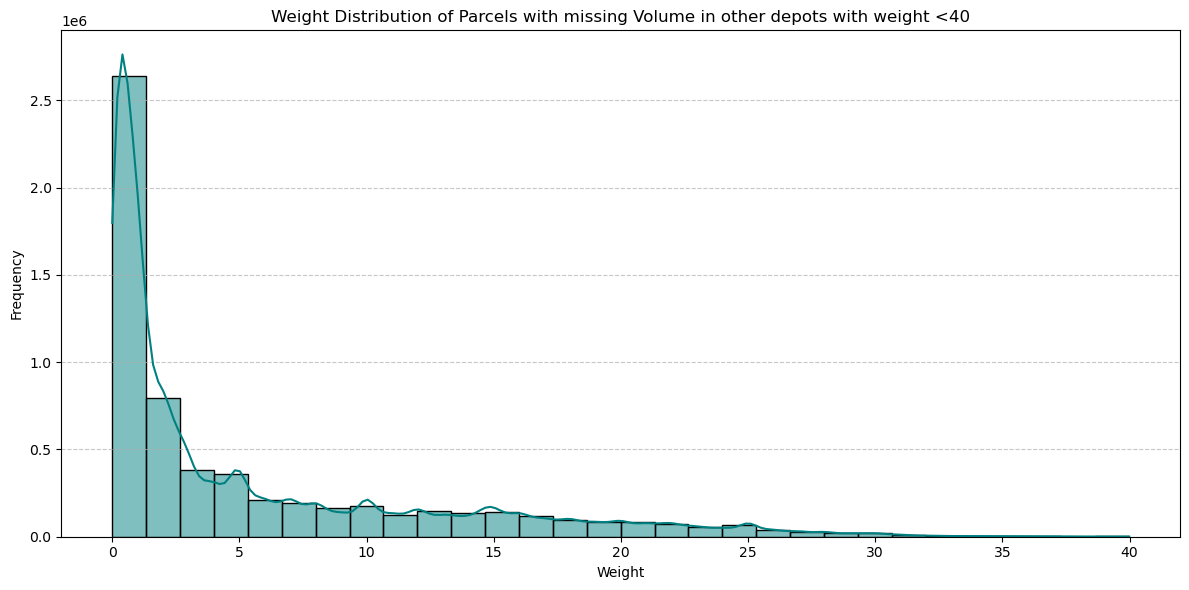

In [228]:
other_lowweight = df_novolume_other[df_novolume_other['WEIGHT'] < 40]
# Plot weight distribution
plt.figure(figsize=(12, 6))

# Plotting histogram
sns.histplot(other_lowweight['WEIGHT'].dropna(), kde=True, bins=30, color='teal')

# Customize the plot
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution of Parcels with missing Volume in other depots with weight <40')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


Weight distribution is similar for all depots and our specific group.

In [126]:
# Define depot_120 as rows where DESTINATION_DEPOT_ID is 120
depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Define other_depots as rows where DESTINATION_DEPOT_ID is not 120
other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]


# Calculate the total number of observations for depot 120
total_observations_depot_120 = len(depot_120)

# Calculate the total number of observations for other depots
total_observations_other_depots = len(other_depots)

# Count the number of 'on time' deliveries for depot 120
on_time_depot_120 = depot_120['ON_TIME'].sum()

# Count the number of 'on time' deliveries for other depots
on_time_other_depots = other_depots['ON_TIME'].sum()

# Calculate the percentage of 'on time' deliveries for depot 120
percentage_on_time_depot_120 = (on_time_depot_120 / total_observations_depot_120) * 100

# Calculate the percentage of 'on time' deliveries for other depots
percentage_on_time_other_depots = (on_time_other_depots / total_observations_other_depots) * 100

# Print results
print(f"Percentage of 'on time' deliveries for Depot 120: {percentage_on_time_depot_120:.2f}%")
print(f"Percentage of 'on time' deliveries for Other Depots: {percentage_on_time_other_depots:.2f}%")


Percentage of 'on time' deliveries for Depot 120: 68.13%
Percentage of 'on time' deliveries for Other Depots: 84.83%


In [127]:
# Ensure the ON_TIME column is boolean
df_120['ON_TIME'] = df_120['ON_TIME'].astype(bool)

# Step 2: Group by 'EVENT_REASON' and calculate the percentage of ON_TIME being False for depot 120
on_time_false_percentage = df_120.groupby('EVENT_REASON')['ON_TIME'].apply(lambda x: (x == False).mean() * 100)

# Step 3: Filter for event reasons where the percentage of ON_TIME being False is 100%
on_time_100_false = on_time_false_percentage[on_time_false_percentage == 100]

# Print the results
print(on_time_100_false)

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_76032/3130631053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_120['ON_TIME'] = df_120['ON_TIME'].astype(bool)


EVENT_REASON
0-1489     100.0
12-0       100.0
145-32     100.0
17-0       100.0
2-124      100.0
26-347     100.0
26-439     100.0
26-58      100.0
26-67      100.0
26-68      100.0
26-932     100.0
27-347     100.0
27-439     100.0
27-68      100.0
27-931     100.0
3-124      100.0
35-129     100.0
35-211     100.0
35-24      100.0
35-32      100.0
35-41      100.0
35-483     100.0
4-1065     100.0
4-24       100.0
4-32       100.0
4-40       100.0
4-41       100.0
4-483      100.0
42-0       100.0
46-1061    100.0
49-0       100.0
49-174     100.0
49-175     100.0
49-177     100.0
49-178     100.0
49-259     100.0
700-928    100.0
74-0       100.0
79-264     100.0
8-161      100.0
8-20       100.0
8-24       100.0
8-32       100.0
8-38       100.0
8-787      100.0
8-80       100.0
83-897     100.0
85-1027    100.0
92-919     100.0
953-932    100.0
Name: ON_TIME, dtype: float64


In [132]:
# Ensure the ON_TIME column is boolean
df_120['ON_TIME'] = df_120['ON_TIME'].astype(bool)

# Step 2: Group by 'EVENT_REASON' and calculate the percentage of ON_TIME being False for depot 120
on_time_false_percentage = df_120.groupby('EVENT_REASON')['ON_TIME'].apply(lambda x: (x == False).mean() * 100)

# Step 3: Calculate the frequency of each EVENT_REASON
event_reason_frequency = df_120['EVENT_REASON'].value_counts()

# Step 4: Calculate the total number of rows for frequency percentage calculation
total_rows = len(df_120)

# Step 5: Calculate the frequency percentage for each EVENT_REASON
event_reason_frequency_percentage = (event_reason_frequency / total_rows) * 100

# Step 6: Create a DataFrame with the percentage of ON_TIME being False, the frequency, and the frequency percentage
on_time_100_false_df = pd.DataFrame({
    'Percentage_ON_TIME_False': on_time_false_percentage,
    'Frequency': event_reason_frequency,
    'Frequency_Percentage': event_reason_frequency_percentage
})

# Step 7: Filter for event reasons where the percentage of ON_TIME being False is 100%
on_time_100_false_df = on_time_100_false_df[on_time_100_false_df['Percentage_ON_TIME_False'] == 100]

# Step 8: Sort the DataFrame by 'Frequency' in descending order
on_time_100_false_df = on_time_100_false_df.sort_values(by='Frequency', ascending=False)

# Print the results
print(on_time_100_false_df)


         Percentage_ON_TIME_False  Frequency  Frequency_Percentage
49-178                      100.0        268              0.053177
49-174                      100.0         32              0.006350
0-1489                      100.0         27              0.005357
12-0                        100.0         24              0.004762
8-32                        100.0         24              0.004762
8-80                        100.0         17              0.003373
49-177                      100.0         17              0.003373
8-20                        100.0         11              0.002183
49-259                      100.0         10              0.001984
4-24                        100.0          7              0.001389
35-24                       100.0          7              0.001389
27-931                      100.0          6              0.001191
85-1027                     100.0          6              0.001191
4-32                        100.0          5              0.00

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_76032/4191724874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_120['ON_TIME'] = df_120['ON_TIME'].astype(bool)
